In [1]:
import pdblp
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import math
from scipy.optimize import minimize  # optimization function
from tqdm import tqdm  # this will just make thing a bit prettier

In [2]:
%matplotlib inline

In [3]:
con = pdblp.BCon(debug=True, port=8194, timeout=5000)
con.debug = False
con.start()

### Parametros iniciais

In [4]:
# cod_bbg = ['AUD', 'CAD', 'CHF', 'DEM','GBP','JPY','NOK','NZD','SEK']
cod_bbg = ['AUD', 'CAD', 'CHF', 'DEM','GBP','JPY','NOK','NZD','SEK'] #Com EUR
cod_spot = [c + ' Curncy' for c in cod_bbg]
campo = ['PX_LAST']
data_ini = '19910101'
data_fim = '20190702'
# data_fim = '20190527'

In [5]:
cod_spot

['AUD Curncy',
 'CAD Curncy',
 'CHF Curncy',
 'DEM Curncy',
 'GBP Curncy',
 'JPY Curncy',
 'NOK Curncy',
 'NZD Curncy',
 'SEK Curncy']

In [6]:
FX_ticker = dict(zip(cod_bbg, cod_spot))
ticker_FX = dict(zip(cod_spot, cod_bbg))
ticker_FX

{'AUD Curncy': 'AUD',
 'CAD Curncy': 'CAD',
 'CHF Curncy': 'CHF',
 'DEM Curncy': 'DEM',
 'GBP Curncy': 'GBP',
 'JPY Curncy': 'JPY',
 'NOK Curncy': 'NOK',
 'NZD Curncy': 'NZD',
 'SEK Curncy': 'SEK'}

### Spots e fwd points

We consider all G10 currencies vis-a-vis the US dollar, including the Australian dollar, the British pound, the Canadian dollar, the euro (Deutsche mark before 1999), the Japanese yen, the New Zealand dollar, the Norwegian krone, the Swiss franc and the Swedish krona.

We use monthly end-of-period data, with the sample spanning the period from January 1991 to December 2015.

 

### Spots

 

In [7]:
spot_last = con.bdh(cod_spot, ['PX_LAST'], data_ini, data_fim, elms=[("periodicitySelection", "MONTHLY")])
spot_last.columns=spot_last.columns.droplevel(1)
spot_last.fillna(method='ffill',inplace=True)
spot_last.columns = [x.replace(' Curncy','') for x in spot_last.columns]
spot_last.sort_index(axis=1,ascending=True,inplace=True)
spot_last.tail()

,AUD,CAD,CHF,DEM,GBP,JPY,NOK,NZD,SEK
date,,,,,,,,,
2019-02-28,0.7094,1.3172,0.9982,1.7200,1.3263,111.39,8.5619,0.6807,9.2386
2019-03-29,0.7096,1.3349,0.9952,1.7434,1.3035,110.86,8.6267,0.6804,9.2917
2019-04-30,0.7048,1.3388,1.0193,1.7439,1.3032,111.42,8.6297,0.6675,9.4883
2019-05-31,0.6938,1.3516,1.0006,1.7511,1.2629,108.29,8.7573,0.6531,9.4961
2019-06-28,0.7020,1.3095,0.9763,1.7200,1.2696,107.85,8.5326,0.6718,9.2845


### Fwd points

 

In [8]:
cod_fwdpts = [c + '1M BGN Curncy' for c in cod_bbg]
cod_fwdpts

['AUD1M BGN Curncy',
 'CAD1M BGN Curncy',
 'CHF1M BGN Curncy',
 'DEM1M BGN Curncy',
 'GBP1M BGN Curncy',
 'JPY1M BGN Curncy',
 'NOK1M BGN Curncy',
 'NZD1M BGN Curncy',
 'SEK1M BGN Curncy']

In [9]:
df_tickers = pd.DataFrame(index=cod_bbg,data=cod_spot, columns=['spot'])
df_tickers['fwdpts'] = cod_fwdpts
df_tickers.loc['DEM','fwdpts'] = df_tickers.loc['DEM','fwdpts'].replace('BGN','CMPN')
df_tickers

,spot,fwdpts
AUD,AUD Curncy,AUD1M BGN Curncy
CAD,CAD Curncy,CAD1M BGN Curncy
CHF,CHF Curncy,CHF1M BGN Curncy
DEM,DEM Curncy,DEM1M CMPN Curncy
GBP,GBP Curncy,GBP1M BGN Curncy
JPY,JPY Curncy,JPY1M BGN Curncy
NOK,NOK Curncy,NOK1M BGN Curncy
NZD,NZD Curncy,NZD1M BGN Curncy
SEK,SEK Curncy,SEK1M BGN Curncy


In [10]:
df_scale = con.ref(list(df_tickers['spot']), 'FWD_SCALE').set_index(keys='ticker', drop=True)
df_scale.index = [x.replace(' Curncy','') for x in df_scale.index]
df_tickers['scale'] = 10 ** df_scale['value']
df_tickers

,spot,fwdpts,scale
AUD,AUD Curncy,AUD1M BGN Curncy,10000
CAD,CAD Curncy,CAD1M BGN Curncy,10000
CHF,CHF Curncy,CHF1M BGN Curncy,10000
DEM,DEM Curncy,DEM1M CMPN Curncy,10000
GBP,GBP Curncy,GBP1M BGN Curncy,10000
JPY,JPY Curncy,JPY1M BGN Curncy,100
NOK,NOK Curncy,NOK1M BGN Curncy,10000
NZD,NZD Curncy,NZD1M BGN Curncy,10000
SEK,SEK Curncy,SEK1M BGN Curncy,10000


In [11]:
fwd_pts_last = con.bdh(list(df_tickers['fwdpts']), ['PX_LAST'], data_ini, data_fim, elms=[("periodicitySelection", "MONTHLY")])
fwd_pts_last.columns=fwd_pts_last.columns.droplevel(1)
fwd_pts_last.fillna(method='ffill',inplace=True)
fwd_pts_last.columns = [x.replace('1M BGN Curncy','') for x in fwd_pts_last.columns]
fwd_pts_last.columns = [x.replace('1M CMPN Curncy','') for x in fwd_pts_last.columns]
fwd_pts_last.sort_index(axis=1,ascending=True,inplace=True)
fwd_pts_last.tail()

,AUD,CAD,CHF,DEM,GBP,JPY,NOK,NZD,SEK
date,,,,,,,,,
2019-02-28,3.69,-10.03,-29.30,-44.85,21.30,-27.60,-119.00,4.40,-226.90
2019-03-29,4.15,-10.18,-28.27,-44.15,19.70,-30.03,-101.23,3.79,-207.57
2019-04-30,5.45,-10.97,-30.78,-46.65,22.21,-29.18,-109.28,3.90,-240.50
2019-05-31,6.60,-10.71,-29.97,-46.10,20.42,-27.30,-104.11,4.40,-226.50
2019-06-28,7.62,-9.55,-28.55,-44.10,19.74,-25.83,-88.54,4.76,-218.46


### Forwards

In [12]:
#Ajustando só o JPY, que tem fwd pts dividido por 100.
df_fwd_last = spot_last + fwd_pts_last / df_tickers['scale']
df_fwd_last.tail()

,AUD,CAD,CHF,DEM,GBP,JPY,NOK,NZD,SEK
date,,,,,,,,,
2019-02-28,0.709769,1.316197,0.995270,1.715515,1.328430,111.1140,8.550000,0.681140,9.215910
2019-03-29,0.710015,1.333882,0.992373,1.738985,1.305470,110.5597,8.616577,0.680779,9.270943
2019-04-30,0.705345,1.337703,1.016222,1.739235,1.305421,111.1282,8.618772,0.667890,9.464250
2019-05-31,0.694460,1.350529,0.997603,1.746490,1.264942,108.0170,8.746889,0.653540,9.473450
2019-06-28,0.702762,1.308545,0.973445,1.715590,1.271574,107.5917,8.523746,0.672276,9.262654


### Spot and fwd in USDXXX (FX/USD)

In [13]:
df_inverse = con.ref(cod_spot, 'INVERSE_QUOTED').set_index(keys='ticker', drop=True)
df_inverse.index = [x.replace(' Curncy','') for x in df_inverse.index]
# df_inverse[df_inverse['value']=="Y"]['value'] = -1
df_inverse.loc[df_inverse['value']=="Y", 'value'] = -1
df_inverse.loc[df_inverse['value']=="N", 'value'] = 1
df_tickers['inverse'] = df_inverse['value']
df_tickers

,spot,fwdpts,scale,inverse
AUD,AUD Curncy,AUD1M BGN Curncy,10000,-1
CAD,CAD Curncy,CAD1M BGN Curncy,10000,1
CHF,CHF Curncy,CHF1M BGN Curncy,10000,1
DEM,DEM Curncy,DEM1M CMPN Curncy,10000,1
GBP,GBP Curncy,GBP1M BGN Curncy,10000,-1
JPY,JPY Curncy,JPY1M BGN Curncy,100,1
NOK,NOK Curncy,NOK1M BGN Curncy,10000,1
NZD,NZD Curncy,NZD1M BGN Curncy,10000,-1
SEK,SEK Curncy,SEK1M BGN Curncy,10000,1


In [14]:
spot_last_USDXXX = spot_last ** df_tickers['inverse']
fwd_last_USDXXX = df_fwd_last ** df_tickers['inverse']

### fwd discount

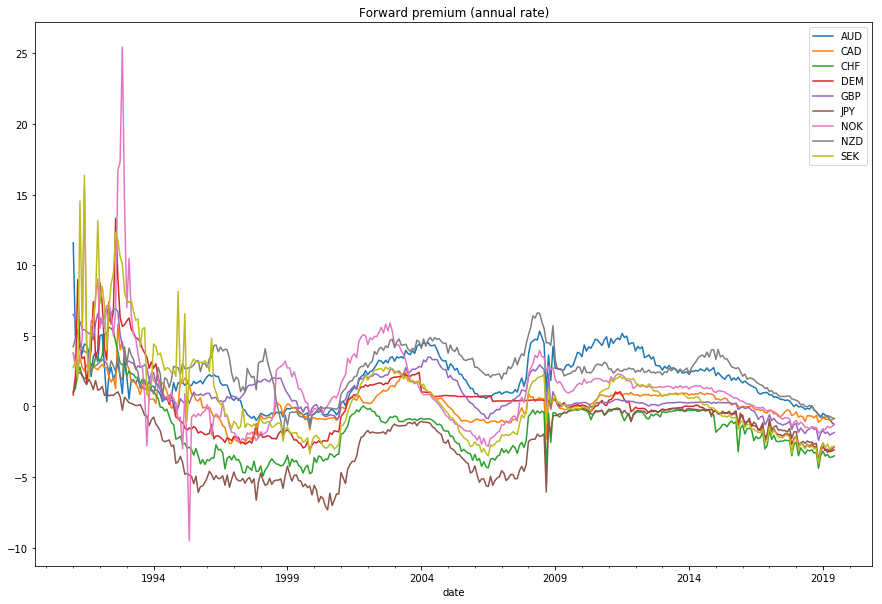

In [15]:
fwd_discount_last = (fwd_last_USDXXX / spot_last_USDXXX - 1) * 12
fwd_discount_last.multiply(100).plot(figsize=(15,10), title='Forward premium (annual rate)')

#### Forward premium since 1999

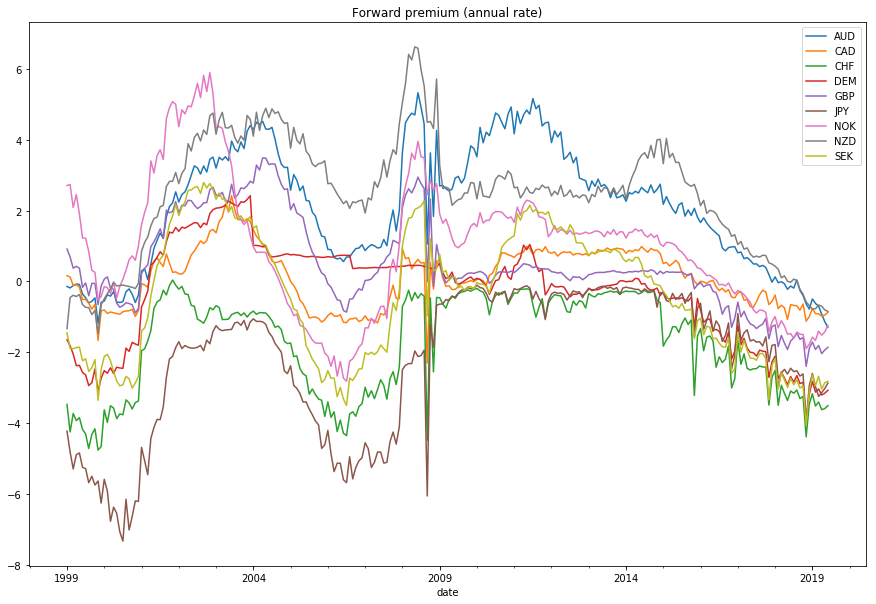

In [16]:
fwd_discount_last["1999":].multiply(100).plot(figsize=(15,10), title='Forward premium (annual rate)')

# Signals

In [17]:
# def ranking_to_wgt(df_ranking, k):
#     assert df_ranking.isnull().sum().sum() == 0, 'There is NaN in ranking DataFrame!! Check this!!'
#     df_aux = pd.DataFrame(index=df_ranking.index, columns=['wgt', 'up_limit', 'down_limit', 'NA'])
#     df_aux['wgt'] = 1.0 / (k * 2.0)
#     df_aux['NA'] = [df_ranking.loc[d].isnull().sum() for d in df_ranking.index]
#     df_aux['up_limit'] = len(df_ranking.columns) - k
#     df_aux['up_limit'] = df_aux['up_limit'] - df_aux['NA']
#     df_aux['down_limit'] = k
#     for d in df_ranking.index:
#         df_ranking.loc[d]
#...CODIGO DESCONTINUADO, POIS DEMORADO.. SE IMPUSER CONDICAO DE NAO NAN, FICA BEM MAIS RAPIDO

## Weighting function

### Equal weight
wgt = 1/k

In [18]:
def ranking_to_wgt(df_ranking, k=1):
    assert df_ranking.isnull().sum().sum() == 0, 'There is NaN in ranking DataFrame!! Check this!!'
    unit_wgt = 1.0 / k
    up_limit = len(df_ranking.columns) - k
    down_limit = k
    df_signals = (df_ranking > up_limit).multiply(1) - (df_ranking <= down_limit).multiply(1)
    weights = df_signals * unit_wgt
    return weights, df_signals
#ex: ranking_to_wgt(ranks_discount, 4)

### Equal vol
wgt_vol_adjusted = wgt/vol

In [19]:
def ranking_to_equalvolwgt(df_ranking, df_vols, target_vol=0.06, k=1):
    assert df_ranking.isnull().sum().sum() == 0, 'There is NaN in ranking DataFrame!! Check this!!'
    assert df_vols.isnull().sum().sum() == 0, 'There is NaN in vols DataFrame!! Check this!!'
    unit_wgt = 1.0 / k
    up_limit = len(df_ranking.columns) - k
    down_limit = k
    df_signals = (df_ranking > up_limit).multiply(1) - (df_ranking <= down_limit).multiply(1)
    weights = df_signals * unit_wgt * target_vol / df_vols
    return weights, df_signals
#ex: ranking_to_wgt(ranks_discount, 4)

#### Forward Discount ranking

In [20]:
#Inicializando DataFrame
calendar = fwd_discount_last.index
lst_currencies = df_tickers.index
ranks_discount = pd.DataFrame(index=calendar, columns=lst_currencies)

In [21]:
for d in fwd_discount_last.index:
    available_FX = list(fwd_discount_last.loc[d].dropna(how='any').index)
    ranks_discount.loc[d,available_FX] = fwd_discount_last.loc[d, available_FX].rank(ascending=True)

In [22]:
ranks_discount.tail()

,AUD,CAD,CHF,DEM,GBP,JPY,NOK,NZD,SEK
date,,,,,,,,,
2019-02-28,9,7,1,2,5,3,6,8,4
2019-03-29,8,7,1,3,5,2,6,9,4
2019-04-30,8,7,1,2,5,3,6,9,4
2019-05-31,7,8,1,2,5,3,6,9,4
2019-06-28,6,8,1,2,5,3,7,9,4


#### Vol ranking

In [23]:
#Getting spot data before 1991 (extended period)
vol_data_ini = '19890101'
spot_last_extended = con.bdh(cod_spot, ['PX_LAST'], vol_data_ini, data_fim, elms=[("periodicitySelection", "DAILY")])
spot_last_extended.columns=spot_last_extended.columns.droplevel(1)
spot_last_extended.fillna(method='ffill',inplace=True)
spot_last_extended.columns = [x.replace(' Curncy','') for x in spot_last_extended.columns]
spot_last_extended.sort_index(axis=1,ascending=True,inplace=True)
spot_last_extended.head()

,AUD,CAD,CHF,DEM,GBP,JPY,NOK,NZD,SEK
date,,,,,,,,,
1989-01-02,0.8555,1.1928,1.5020,1.7735,1.8110,125.05,6.5650,0.632,6.131
1989-01-03,0.8695,1.1907,1.4973,1.7640,1.8243,123.60,6.5075,0.637,6.096
1989-01-04,0.8720,1.1921,1.5188,1.7879,1.8070,125.05,6.5810,0.638,6.160
1989-01-05,0.8700,1.1895,1.5310,1.7950,1.7985,125.59,6.5930,0.640,6.180
1989-01-06,0.8630,1.1952,1.5490,1.8140,1.7892,126.62,6.6450,0.638,6.230


In [24]:
#Converting in USDXXX (FX/USD) format
spot_last_USDXXX_extended = spot_last_extended ** df_tickers['inverse']
spot_last_USDXXX_extended.head()

,AUD,CAD,CHF,DEM,GBP,JPY,NOK,NZD,SEK
date,,,,,,,,,
1989-01-02,1.16891,1.1928,1.502,1.7735,0.552181,125.05,6.565,1.58228,6.131
1989-01-03,1.15009,1.1907,1.4973,1.764,0.548155,123.6,6.5075,1.56986,6.096
1989-01-04,1.14679,1.1921,1.5188,1.7879,0.553403,125.05,6.581,1.5674,6.16
1989-01-05,1.14943,1.1895,1.531,1.795,0.556019,125.59,6.593,1.5625,6.18
1989-01-06,1.15875,1.1952,1.549,1.814,0.558909,126.62,6.645,1.5674,6.23


#### EWMA Vol (Lambda = 0.97)

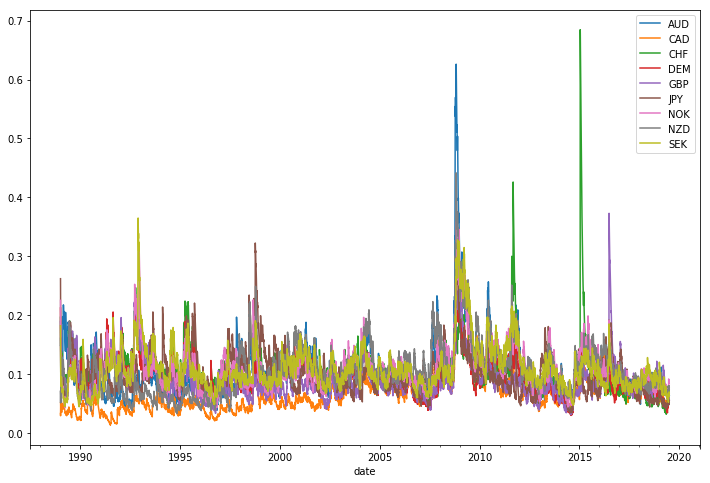

In [25]:
### EWM (Pandas)
vol_calendar = spot_last_USDXXX_extended.index
df_vols = pd.DataFrame(index=vol_calendar, columns=lst_currencies)
ewma_lambda = 0.94
df_vols = spot_last_USDXXX_extended.pct_change(1).ewm(com=None, span=None,halflife=None,alpha=(1.0-ewma_lambda),min_periods=0,adjust=True).var() * 252
df_vols = df_vols ** 0.5
df_vols.plot(figsize=(12,8))

In [26]:
### EWMA
# vol_calendar = spot_last_USDXXX_extended.index
# df_vols = pd.DataFrame(index=vol_calendar, columns=lst_currencies)
# ewma_lambda = 0.94
# df_vols.loc[vol_calendar[0]] = spot_last_USDXXX_extended.pct_change(1).var()
# for d, dm1 in zip(vol_calendar[1:], vol_calendar[:-1]):
#     df_vols.loc[d] = (np.log((spot_last_USDXXX_extended.loc[d] / spot_last_USDXXX_extended.loc[dm1]).astype(float))**2)* (1.0 - ewma_lambda) + ewma_lambda * df_vols.loc[dm1]
# df_vols = (df_vols * 252) ** 0.5
# df_vols.plot(figsize=(12,8))

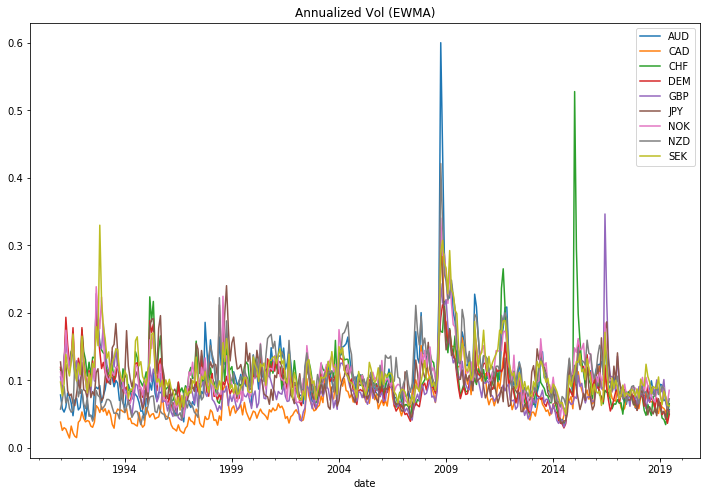

In [27]:
#Monthly DataFrame
df_vols_monthly = pd.DataFrame(index=calendar, columns=lst_currencies)
for d in calendar:
    df_vols_monthly.loc[d] = df_vols.loc[d]
df_vols_monthly.plot(figsize=(12,8), title='Annualized Vol (EWMA)')

# P&L of traditional carry trade

In [28]:
def pnl_fwd_dsc(df_forwards, df_spots, df_ranking, k):
    #d=day, tm1=t menos 1
    TR_index = pd.DataFrame(index=df_ranking.index, columns=['TR_index'])
    holdings = pd.DataFrame(index=df_ranking.index, columns=df_ranking.columns)
    d_ini = TR_index.index[0]
    TR_index.loc[d_ini] = 100.0
    [weights, signals] = ranking_to_wgt(df_ranking, k)
    #Holdings have inverted signal, as FX is USDXXX and negative signal is long XXX/Short USD.
    holdings.loc[d_ini] = ((100.0 * weights.loc[d_ini]) / df_forwards.loc[d_ini]).multiply(-1) #df_forwards should be in USDXXX
    
    for d, tm1 in zip(df_ranking.index[1:], df_ranking.index[:-1]):
        pnl = (holdings.loc[tm1] * (df_forwards.loc[tm1] - df_spots.loc[d])).sum()
        TR_index.loc[d] = TR_index.loc[tm1] + pnl
        holdings.loc[d] = TR_index.loc[d].values * weights.loc[d] / df_forwards.loc[d]
    return TR_index, holdings, weights, signals
#ex: pnl_fwd_dsc(fwd_last_USDXXX, spot_last_USDXXX, ranks_discount, k=1)

In [29]:
[TR_index1, holdings1, weights1, signals1] = pnl_fwd_dsc(fwd_last_USDXXX, spot_last_USDXXX, ranks_discount, k=1)
[TR_index2, holdings2, weights2, signals2] = pnl_fwd_dsc(fwd_last_USDXXX, spot_last_USDXXX, ranks_discount, k=2)
[TR_index3, holdings3, weights3, signals3] = pnl_fwd_dsc(fwd_last_USDXXX, spot_last_USDXXX, ranks_discount, k=3)
[TR_index4, holdings4, weights4, signals4] = pnl_fwd_dsc(fwd_last_USDXXX, spot_last_USDXXX, ranks_discount, k=4)

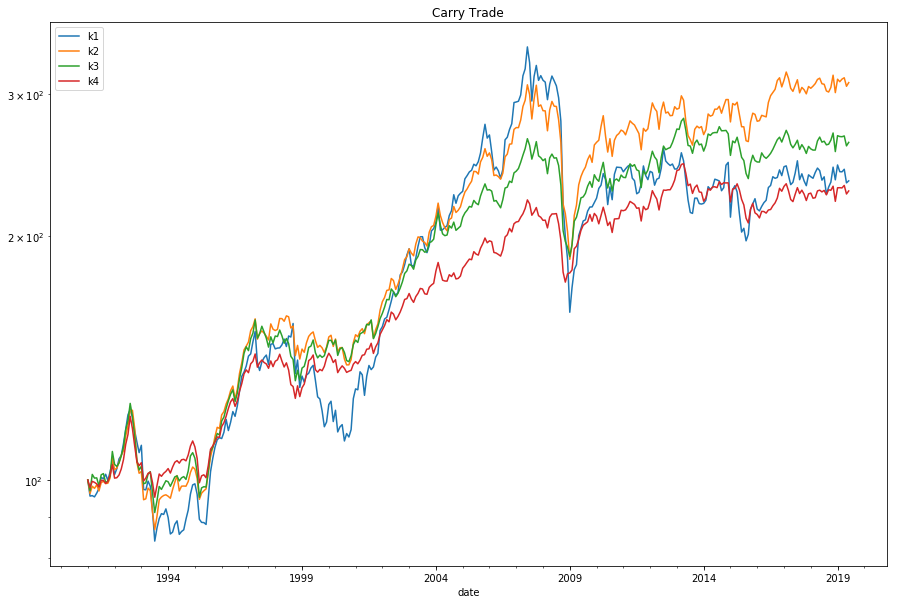

In [30]:
TR_dsc = pd.DataFrame(index=TR_index1.index, columns=['k1','k2','k3','k4'])
TR_dsc['k1'] = TR_index1
TR_dsc['k2'] = TR_index2
TR_dsc['k3'] = TR_index3
TR_dsc['k4'] = TR_index4
TR_dsc.plot(figsize=(15,10), title='Carry Trade', logy=True)

# P&L of equal vol carry trade

In [31]:
def pnl_equal_vol(df_forwards, df_spots, df_ranking, df_vol, target_vol, k):
    #d=day, tm1=t menos 1
    TR_index = pd.DataFrame(index=df_ranking.index, columns=['TR_index'])
    holdings = pd.DataFrame(index=df_ranking.index, columns=df_ranking.columns)
    d_ini = TR_index.index[0]
    TR_index.loc[d_ini] = 100.0
    [weights, signals] = ranking_to_equalvolwgt(df_ranking, df_vol, target_vol, k)
    #Holdings have inverted signal, as FX is USDXXX and negative signal is long XXX/Short USD.
    holdings.loc[d_ini] = ((100.0 * weights.loc[d_ini]) / df_forwards.loc[d_ini]).multiply(-1) #df_forwards should be in USDXXX
    
    for d, tm1 in zip(df_ranking.index[1:], df_ranking.index[:-1]):
        pnl = (holdings.loc[tm1] * (df_forwards.loc[tm1] - df_spots.loc[d])).sum()
        TR_index.loc[d] = TR_index.loc[tm1] + pnl
        holdings.loc[d] = TR_index.loc[d].values * weights.loc[d] / df_forwards.loc[d]
    return TR_index, holdings, weights, signals
#ex: pnl_fwd_dsc(fwd_last_USDXXX, spot_last_USDXXX, ranks_discount, k=1)

In [32]:
tgt_vol = 0.09
[TR_dsc_ev1, holdings_dsc_ev1, weights_dsc_ev1, signals_dsc_ev1] = pnl_equal_vol(fwd_last_USDXXX, spot_last_USDXXX, ranks_discount, df_vols_monthly, target_vol=tgt_vol, k=1)
[TR_dsc_ev2, holdings_dsc_ev2, weights_dsc_ev2, signals_dsc_ev2] = pnl_equal_vol(fwd_last_USDXXX, spot_last_USDXXX, ranks_discount, df_vols_monthly, target_vol=tgt_vol, k=2)
[TR_dsc_ev3, holdings_dsc_ev3, weights_dsc_ev3, signals_dsc_ev3] = pnl_equal_vol(fwd_last_USDXXX, spot_last_USDXXX, ranks_discount, df_vols_monthly, target_vol=tgt_vol, k=3)
[TR_dsc_ev4, holdings_dsc_ev4, weights_dsc_ev4, signals_dsc_ev4] = pnl_equal_vol(fwd_last_USDXXX, spot_last_USDXXX, ranks_discount, df_vols_monthly, target_vol=tgt_vol, k=4)

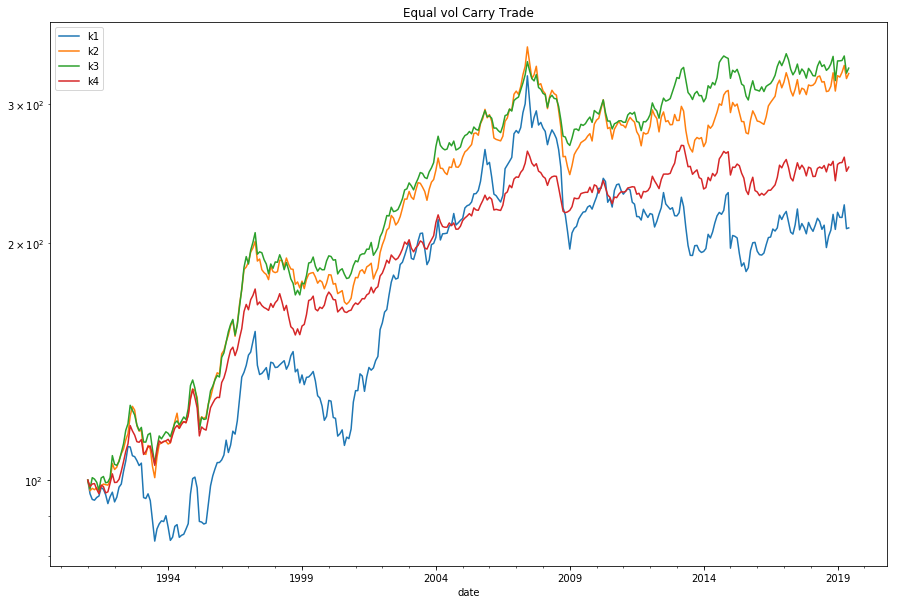

In [33]:
TR_dsc_ev = pd.DataFrame(index=TR_dsc_ev1.index, columns=['k1','k2','k3','k4'])
TR_dsc_ev['k1'] = TR_dsc_ev1
TR_dsc_ev['k2'] = TR_dsc_ev2
TR_dsc_ev['k3'] = TR_dsc_ev3
TR_dsc_ev['k4'] = TR_dsc_ev4
TR_dsc_ev.plot(figsize=(15,10), title='Equal vol Carry Trade', logy=True)

### Tables 04 and 05

In [34]:
iterables = [['Forward discount', 'Curvature'], range(1,5)]
idx = pd.MultiIndex.from_product(iterables, names=['Strategy', 'k'])
table04_Funding = pd.DataFrame(index=idx, columns=df_tickers.index)
table05_Investing = pd.DataFrame(index=idx, columns=df_tickers.index)

In [35]:
#table04 Funding Currencies
table04_Funding.loc[('Forward discount', 1)] = (signals1<-0.01).sum()
table04_Funding.loc[('Forward discount', 2)] = (signals2<-0.01).sum()
table04_Funding.loc[('Forward discount', 3)] = (signals3<-0.01).sum()
table04_Funding.loc[('Forward discount', 4)] = (signals4<-0.01).sum()
#table05 Investing Currencies
table05_Investing.loc[('Forward discount', 1)] = (signals1>0.01).sum()
table05_Investing.loc[('Forward discount', 2)] = (signals2>0.01).sum()
table05_Investing.loc[('Forward discount', 3)] = (signals3>0.01).sum()
table05_Investing.loc[('Forward discount', 4)] = (signals4>0.01).sum()

In [36]:
table04_Funding

AUD  CAD  CHF  DEM  GBP  JPY  NOK  NZD  SEK
Strategy         k                                             
Forward discount 1    1    0  120    1    0  217    2    0    1
                 2    9   16  310   19    0  278    4    1   47
                 3   23   63  318  151   11  308   30   11  111
                 4   27  120  329  234   56  342   74   21  165
Curvature        1  NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN
                 2  NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN
                 3  NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN
                 4  NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN

In [37]:
table05_Investing

AUD  CAD  CHF  DEM  GBP  JPY  NOK  NZD  SEK
Strategy         k                                             
Forward discount 1   58    0    0    9   10    0   55  177   33
                 2  195    6    0   23   51    0   75  284   50
                 3  278   42    2   47  108    0  190  292   67
                 4  305  109    4   84  197    0  236  304  129
Curvature        1  NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN
                 2  NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN
                 3  NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN
                 4  NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN

### Curves

In [38]:
bbgcurve_dict = {'AUD':'YCSW0001 Index',
                 'CAD':'YCSW0004 Index',
                 'CHF':'YCSW0021 Index',
                 'DEM':'YCGT0054 Index',
                 'GBP':'YCSW0022 Index',
                 'JPY':'YCSW0013 Index',
                 'NOK':'YCSW0016 Index',
                 'NZD':'YCSW0015 Index',
                 'SEK':'YCSW0020 Index',
                 'USD':'YCSW0023 Index',}

tenor_dict = {'1D':1.0/360,
              '2D':2.0/360,
              '1W': 7.0/360,
              '1M': 1.0/12,
              '2M': 2./12,
              '3M': 3.0/12,
              '4M': 4.0/12,
              '5M': 5.0/12,
              '6M': 0.5,
              '1Y': 1.0,
              '18M': 1.5,
              '2Y': 2.0,
              '3Y': 3.0,
              '4Y': 4.0,
              '5Y': 5.0,
              '6Y': 6.0,
              '7Y': 7.0,
              '8Y': 8.0,
              '9Y': 9.0,
              '10Y': 10.0,
              '11Y': 11.0,
              '12Y': 12.0,
              '13Y': 13.0,
              '14Y': 14.0,
              '15Y': 15.0,
              '20Y': 20.0,
              '25Y': 25.0,
              '30Y': 30.0,
              '35Y': 35.0,
              '40Y': 40.0,
              '45Y': 45.0,
              '50Y': 50.0}
def converte_tenors(tenors):
    return [tenor_dict[tenor]*12 for tenor in tenors]

def metadados_curva_bbg(ticker_moeda = 'CHF'):
    ticker_curva = bbgcurve_dict[ticker_moeda]
    ticker_membros = list(con.bulkref(ticker_curva, 'CURVE_MEMBERS')['value'])
    prazos = list(con.bulkref(ticker_curva, 'CURVE_TERMS')['value'])
    df_curve_aux = pd.DataFrame(data=list(zip(prazos, ticker_membros)), columns=['tenor', 'ticker'])
    df_curve_aux['years'] = converte_tenors(list(df_curve_aux.tenor))
    return df_curve_aux

In [39]:
#Exemplo de um DataFrame de metadados da curva da Suica.
metadados_curva_bbg().head()

,tenor,ticker,years
0,1D,SFDR1T Curncy,0.033333
1,1W,SF0001W Index,0.233333
2,1M,SF0001M Index,1.000000
3,2M,SF0002M Index,2.000000
4,3M,SF0003M Index,3.000000


In [40]:
lista_moedas_aux = list(bbgcurve_dict.keys())
#Arruma o primeiro df para receber Append.
moeda1 = lista_moedas_aux[0]
df_metadados_curva = metadados_curva_bbg(moeda1)
idx2 = pd.MultiIndex.from_product(iterables=[[moeda1], df_metadados_curva['years']])
df_metadados_curva.set_index(idx2,drop=True, verify_integrity=True,inplace=True)
#Baixa os outros dados e depois 'append' na df_metadados_curva.
for moeda in lista_moedas_aux[1:]:
    df_metadados_aux = metadados_curva_bbg(moeda)
    idx2 = pd.MultiIndex.from_product(iterables=[[moeda], df_metadados_aux['years']])
    df_metadados_aux.set_index(idx2,drop=True, verify_integrity=True,inplace=True)
    df_metadados_curva = df_metadados_curva.append(other=df_metadados_aux, verify_integrity=True)

In [41]:
#Cria dicionario p/ conversao de ticker p/ ano
ticker_year_dict = dict(zip(df_metadados_curva['ticker'], df_metadados_curva['years']))

In [42]:
df_metadados_curva.loc[(slice(None),5),:]

,,tenor,ticker,years
AUD,5.0,5M,ADBB5M Curncy,5.0
NZD,5.0,5M,NDBB5M Curncy,5.0


In [43]:
df_metadados_curva.xs(7/360*12,level=1)

,tenor,ticker,years
CHF,1W,SF0001W Index,0.233333
GBP,1W,BP0001W Index,0.233333
JPY,1W,JY0001W Index,0.233333
NOK,1W,NIBOR1W Index,0.233333
SEK,1W,STIB1W Index,0.233333
USD,1W,US0001W Index,0.233333


In [44]:
df_metadados_curva.loc['NOK', 'ticker'].values

array(['NKDR1T   Curncy', 'NKDR2T   Curncy', 'NIBOR1W  Index',
       'NIBOR1M  Index', 'NIBOR2M  Index', 'NIBOR3M  Index',
       'NIBOR6M  Index', 'NKSW1V3  Curncy', 'NKSW1FV3 Curncy',
       'NKSW2    Curncy', 'NKSW3    Curncy', 'NKSW4    Curncy',
       'NKSW5    Curncy', 'NKSW6    Curncy', 'NKSW7    Curncy',
       'NKSW8    Curncy', 'NKSW9    Curncy', 'NKSW10   Curncy',
       'NKSW12   Curncy', 'NKSW15   Curncy', 'NKSW20   Curncy',
       'NKSW25   Curncy', 'NKSW30   Curncy'], dtype=object)

In [45]:
def consulta_curva_bbg(lista_tickers = ['US00O/N  Index', 'USDR2T   Curncy'], dt_ini=data_ini, dt_fim=data_fim):
    #Consulta
    df_curva_bbg_aux = con.bdh(lista_tickers, ['PX_LAST'], data_ini, data_fim, elms=[("periodicitySelection", "MONTHLY")])
    #Tratamento
    df_curva_bbg_aux.columns = df_curva_bbg_aux.columns.droplevel(level='field')
    df_curva_bbg_aux.columns = [ticker_year_dict[ticker] for ticker in df_curva_bbg_aux.columns]
    df_curva_bbg_aux.sort_index(axis=1, inplace=True)
    df_curva_bbg_aux.fillna(method='ffill',inplace=True)
    return df_curva_bbg_aux

In [46]:
lista_moedas_aux = list(bbgcurve_dict.keys())
#Arruma o primeiro df para receber Append.
#Parametros
moeda1 = lista_moedas_aux[0]
lista_tickers1 = list(df_metadados_curva.loc[moeda1, 'ticker'].values)
#Consulta
df_curva_bbg = consulta_curva_bbg(lista_tickers1)
#Tratamento
idx3 = pd.MultiIndex.from_product(iterables=[[moeda1], df_curva_bbg.index.values])
df_curva_bbg.set_index(idx3,drop=True, verify_integrity=True,inplace=True)
#Baixa os outros dados e depois 'append' na df_curva_bbg.
for moeda in lista_moedas_aux[1:]:
    #Parametros
    lista_tickers = list(df_metadados_curva.loc[moeda, 'ticker'].values)
    #Consulta
    df_curva_bbg_auxiliar = consulta_curva_bbg(lista_tickers)
    #Tratamento
    idx3 = pd.MultiIndex.from_product(iterables=[[moeda], df_curva_bbg_auxiliar.index.values])
    df_curva_bbg_auxiliar.set_index(idx3,drop=True, verify_integrity=True,inplace=True)
    #Junta os dados
    df_curva_bbg = df_curva_bbg.append(other=df_curva_bbg_auxiliar, verify_integrity=True)

In [47]:
df_curva_bbg.tail()

0.033333    0.066667    0.233333    1.000000    2.000000    \
USD 2019-02-28     2.38275       2.415     2.40775     2.49038     2.56713   
    2019-03-29     2.38200       2.415     2.42300     2.49450     2.56388   
    2019-04-30     2.37913       2.435     2.42538     2.48050     2.52625   
    2019-05-31     2.35450       2.390     2.38925     2.43050     2.47400   
    2019-06-28     2.37038       2.435     2.37238     2.39800     2.33088   

                3.000000    4.000000    5.000000    6.000000    12.000000   \
USD 2019-02-28     2.61513         NaN         NaN     2.68575     2.86488   
    2019-03-29     2.59975         NaN         NaN     2.65950     2.71063   
    2019-04-30     2.57563         NaN         NaN     2.62200     2.71688   
    2019-05-31     2.50250         NaN         NaN     2.51663     2.51025   
    2019-06-28     2.31988         NaN         NaN     2.20050     2.17813   

                   ...      132.000000  144.000000  180.000000  240.000000  \
USD 2019-02-28     ...          2.7560      2.7830      2.8354      2.8755   
    2019-03-29     ...          2.4369      2.4625      2.5178      2.5650   
    2019-04-30     ...          2.5217      2.5502      2.6125      2.6678   
    2019-05-31     ...          2.1165      2.1451      2.2099      2.2666   
    2019-06-28     ...          2.0012      2.0346      2.1085      2.1772   

                300.000000  360.000000  420.000000  480.000000  540.000000  \
USD 2019-02-28      2.8834      2.8830         NaN      2.8586         NaN   
    2019-03-29      2.5786      2.5824         NaN      2.5627         NaN   
    2019-04-30      2.6863      2.6930         NaN      2.6779         NaN   
    2019-05-31      2.2860      2.2940         NaN      2.2770         NaN   
    2019-06-28      2.2037      2.2137         NaN      2.1950         NaN   

                600.000000  
USD 2019-02-28      2.8220  
    2019-03-29      2.5285  
    2019-04-30      2.6485  
    2019-05-31      2.2482  
    2019-06-28      2.1677  

[5 rows x 30 columns]

# Nelson-Siegel

In [48]:
#A funcao recebe um DataFrame de betas b1,b2,b3 (Lambda eh hardcoded) e retorna uma soma de erros quadrados ponderados
def NSiegel(array_betas, df_curve):
    b1 = array_betas[0]
    b2 = array_betas[1]
    b3 = array_betas[2]
    years = np.array(df_curve.columns.values)
    int_rates = df_curve.values[0]
#     _lambda = df_parameters['lambda']
    _lambda = 0.0609 #hardcoded
#     df_y_est = pd.DataFrame(index=tau, columns=['y_est','errors'])
    sum_squared_errors = 0.0
    for tau, rate in zip(years, int_rates):
        _aux = ((1-math.exp(-_lambda*tau))/(_lambda*tau))
        y_tau = b1+b2*_aux+b3*(_aux-math.exp(-_lambda*tau))
        factor = 1.0 #to improve...
        sum_squared_errors = sum_squared_errors + ((rate - y_tau) ** 2) * factor
    return sum_squared_errors

In [49]:
#Example of df_curve_input layout
df_curve_input_ex = df_curva_bbg.loc[('USD','1991-01-31'),:].dropna(how='all', axis=1)
df_curve_input_ex

,,1.0,2.0,3.0,6.0,12.0,24.0,36.0,48.0,60.0,84.0,120.0
USD,1991-01-31,6.9375,7.13,7.06,7.13,7.25,7.66,7.95,8.19,8.33,8.62,8.8


In [50]:
#listas p/ rodar NSiegel
calendar_curves = list(df_curva_bbg.index.get_level_values(1).unique())
# lista_moedas_aux
#DataFrame p/ guardar betas
idx4 = pd.MultiIndex.from_product(iterables=[lista_moedas_aux, calendar_curves])
df_betas = pd.DataFrame(index=idx4, columns=['b1', 'b2', 'b3'])
beta0 = np.ones(3) #b1, b2 e b3

for d in tqdm(calendar_curves, 'Nelson-Siegel Fitting'):
    for moeda in lista_moedas_aux:
        df_curve_input = df_curva_bbg.loc[(moeda, str(d)),:].dropna(how='all', axis=1) #quando d é str, axis=1
#         beta0 = np.ones(3) #b1, b2 e b3
        res = minimize(fun=NSiegel,
                       x0=beta0,
                       args=df_curve_input,
                       method='SLSQP')
        if res.success:
            df_betas.loc[moeda, d] = res.x
df_betas

Nelson-Siegel Fitting: 100%|█████████████████| 342/342 [00:16<00:00, 21.07it/s]


b1         b2         b3
AUD 1991-01-31  12.2921  -0.292569   0.464233
    1991-02-28  12.7045  -0.753483   -1.63408
    1991-03-29  12.2751  -0.204477  -0.470839
    1991-04-30  12.0784  -0.427118   -1.50941
    1991-05-31  12.1277   -1.72729    -1.8796
    1991-06-28  12.1582   -1.15945  -0.256666
    1991-07-31   11.862   -1.31321   0.059582
    1991-08-30  11.5565   -1.00776   0.314199
    1991-09-30  11.2353    -1.6355   -1.19333
    1991-10-31  11.2886   -1.81668   -5.25646
    1991-11-29  11.1318   -2.63105   -3.84861
    1991-12-31  11.2159   -2.56168   -7.48852
    1992-01-31  11.4672   -3.86941   -1.93463
    1992-02-28  11.3012   -3.90423   -1.15962
    1992-03-31  10.7127    -3.1158   0.165244
    1992-04-30  10.7701   -3.21985   -2.86766
    1992-05-29  10.6704   -4.17163   -2.46512
    1992-06-30  10.6056   -3.60409   -5.46265
    1992-07-31  10.3296   -4.57727   -6.40931
    1992-08-31  9.94994   -4.30565   0.655998
    1992-09-30  10.1488   -4.22218  -0.844638
    1992-10-30   9.8426   -4.09773   0.330121
    1992-11-30  10.1003   -4.30451  -0.162236
    1992-12-31  10.1794     -4.353    -1.1936
    1993-01-29  9.54921   -3.77303  -0.551343
    1993-02-26  8.98466   -3.28548   -2.20601
    1993-03-31  9.02605   -3.70764   -2.51236
    1993-04-30  8.61843   -3.36881   -2.99419
    1993-05-31   8.6131   -3.32507    -1.5912
    1993-06-30  8.40578   -3.05616   -2.32057
...                 ...        ...        ...
USD 2017-01-31  2.68397   -1.86234  -0.395883
    2017-02-28  2.64694   -1.83626 -0.0194387
    2017-03-31  2.68479   -1.66037  -0.433045
    2017-04-28  2.53955   -1.51054  -0.429048
    2017-05-31  2.43815   -1.37085  -0.576331
    2017-06-30  2.58646   -1.34398  -0.819593
    2017-07-31  2.59372   -1.33892   -1.00177
    2017-08-31  2.39304   -1.11254  -0.994279
    2017-09-29  2.55334   -1.31107  -0.456421
    2017-10-31  2.60131     -1.338  -0.303605
    2017-11-30  2.58726   -1.28703   0.161134
    2017-12-29  2.52165  -0.981305   0.233965
    2018-01-31  2.80251   -1.27254   0.782769
    2018-02-28  2.89838   -1.28656    1.20281
    2018-03-30  2.75166  -0.878329    1.17407
    2018-04-30  2.94584   -1.06154    1.42944
    2018-05-31  2.87402  -0.969264    1.28619
    2018-06-29  2.87561  -0.830032    1.27273
    2018-07-31  2.97156  -0.945347    1.40553
    2018-08-31  2.88109  -0.833601    1.29543
    2018-09-28  3.08264   -0.85993    1.16857
    2018-10-31  3.19968  -0.910508    1.13605
    2018-11-30  3.03027  -0.660795   0.957224
    2018-12-31  2.75937  -0.191406  0.0082622
    2019-01-31  2.72129  -0.167652 -0.0728533
    2019-02-28  2.83661  -0.318497  -0.293785
    2019-03-29  2.52432  0.0158559  -0.578044
    2019-04-30  2.65172   -0.11828    -0.7942
    2019-05-31  2.26074   0.257328   -1.30811
    2019-06-28  2.22522   0.232543   -1.91367

[3420 rows x 3 columns]

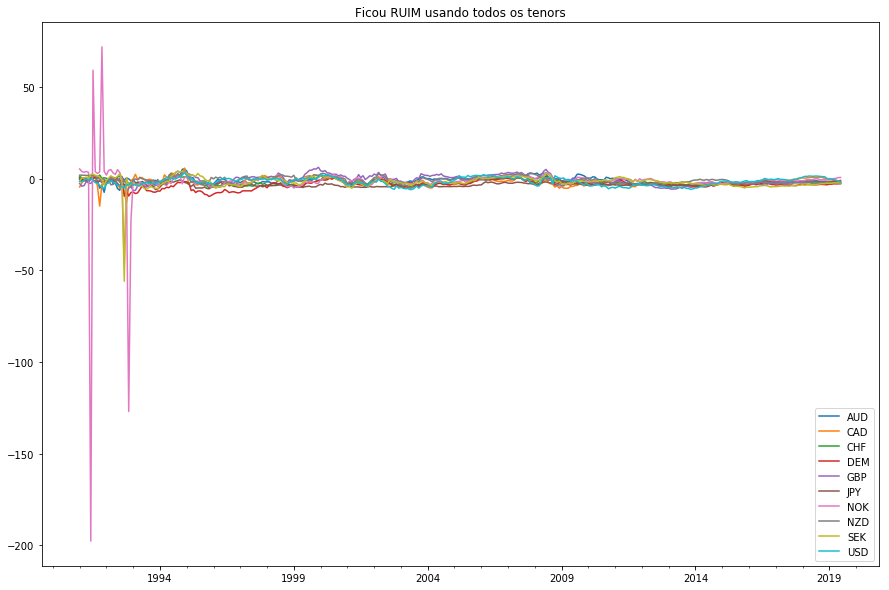

In [51]:
df_curvature_all_tenors = pd.DataFrame(index=calendar_curves, columns=lista_moedas_aux)
for moeda in lista_moedas_aux:
    df_curvature_all_tenors[moeda] = df_betas.loc[(moeda),'b3']
df_curvature_all_tenors.plot(figsize=(15,10), title='Ficou RUIM usando todos os tenors')

### Outliers coming from NOK and SEK, specially from short tenors (Sept 1992)

In [52]:
df_betas.loc[('NOK'),'b3']['1992']

1992-01-31     1.90249
1992-02-28     4.44574
1992-03-31     4.91243
1992-04-30     3.08497
1992-05-29     2.27758
1992-06-30     4.87094
1992-07-31     3.26586
1992-08-31   -0.258729
1992-09-30    -47.2293
1992-10-30    -1.03278
1992-11-30    -127.004
1992-12-31     -22.763
Name: b3, dtype: object

In [53]:
df_curva_bbg.xs('1992-09-30', level=1).T

,AUD,CAD,CHF,DEM,GBP,JPY,NOK,NZD,SEK,USD
0.033333,5.9300,10.000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
0.066667,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,41.00,NaN
0.233333,NaN,NaN,NaN,NaN,NaN,NaN,27.96,NaN,45.00,NaN
1.000000,NaN,8.700,6.8750,NaN,9.2500,4.1250,22.57,NaN,30.00,3.1250
2.000000,NaN,8.350,6.9375,NaN,9.1250,4.0625,17.48,NaN,24.50,3.1875
3.000000,NaN,8.017,6.9375,12.625,9.0625,3.9375,15.76,NaN,20.00,3.1250
4.000000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
5.000000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
6.000000,NaN,7.617,6.9375,NaN,8.8125,3.8750,13.81,6.5138,17.50,3.1875
12.000000,NaN,7.475,6.8125,NaN,8.5625,NaN,NaN,NaN,NaN,3.3125


### New Nelson-Siegel, starting from 3 month tenor...

In [54]:
#listas p/ rodar NSiegel
calendar_curves = list(df_curva_bbg.index.get_level_values(1).unique())
# lista_moedas_aux
#DataFrame p/ guardar betas
idx4 = pd.MultiIndex.from_product(iterables=[lista_moedas_aux, calendar_curves])
df_betas1 = pd.DataFrame(index=idx4, columns=['b1', 'b2', 'b3'])
beta0 = np.ones(3) #b1, b2 e b3

for d in tqdm(calendar_curves, 'Nelson-Siegel Fitting'):
    for moeda in lista_moedas_aux:
        df_curve_input = df_curva_bbg.loc[(moeda, str(d)),:].dropna(how='all', axis=1) #quando d é str, axis=1
        df_curve_input = df_curve_input.loc[:,df_curve_input.columns >=0.25*12]
#         beta0 = np.ones(3) #b1, b2 e b3
        res = minimize(fun=NSiegel,
                       x0=beta0,
                       args=df_curve_input,
                       method='SLSQP')
        if res.success:
            df_betas1.loc[moeda, d] = res.x

Nelson-Siegel Fitting: 100%|█████████████████| 342/342 [00:16<00:00, 20.14it/s]


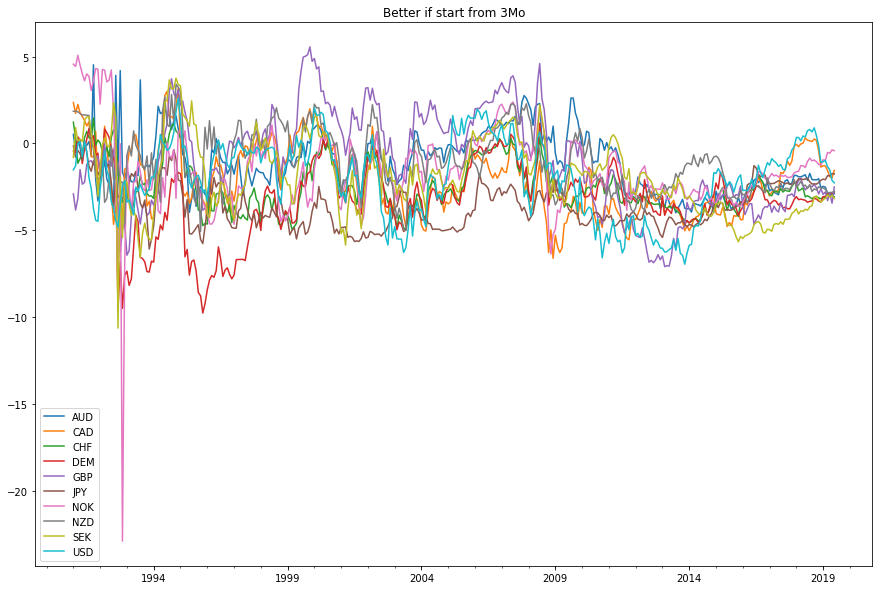

In [55]:
df_curvature_all_tenors1 = pd.DataFrame(index=calendar_curves, columns=lista_moedas_aux)
for moeda in lista_moedas_aux:
    df_curvature_all_tenors1[moeda] = df_betas1.loc[(moeda),'b3']
df_curvature_all_tenors1.plot(figsize=(15,10), title='Better if start from 3Mo')

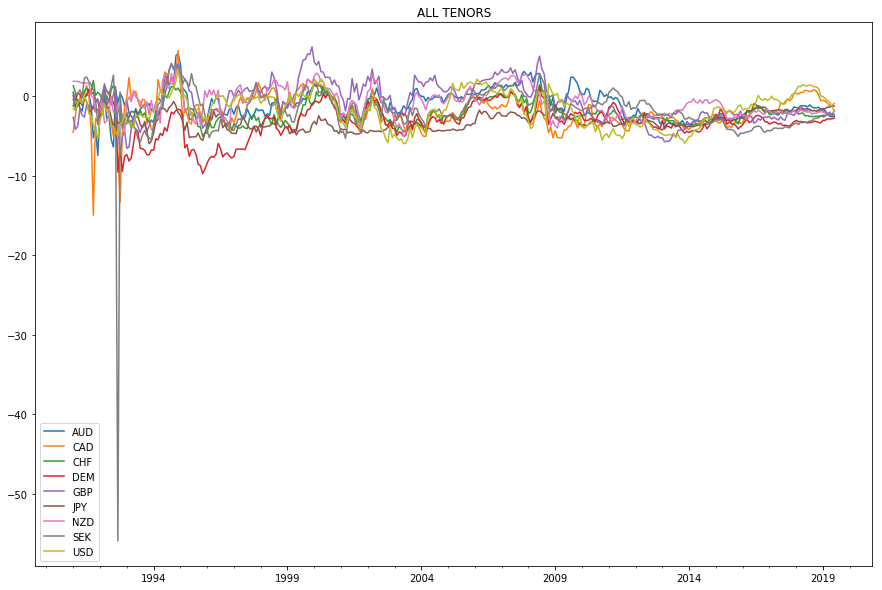

In [56]:
cond1 = df_curvature_all_tenors1.columns != 'NOK'
# cond2 = df_betas_all_tenors1.columns != 'SEK'
cond = cond1 #& cond2
df_curvature_all_tenors.loc[:,cond].plot(figsize=(15,10), title='ALL TENORS')

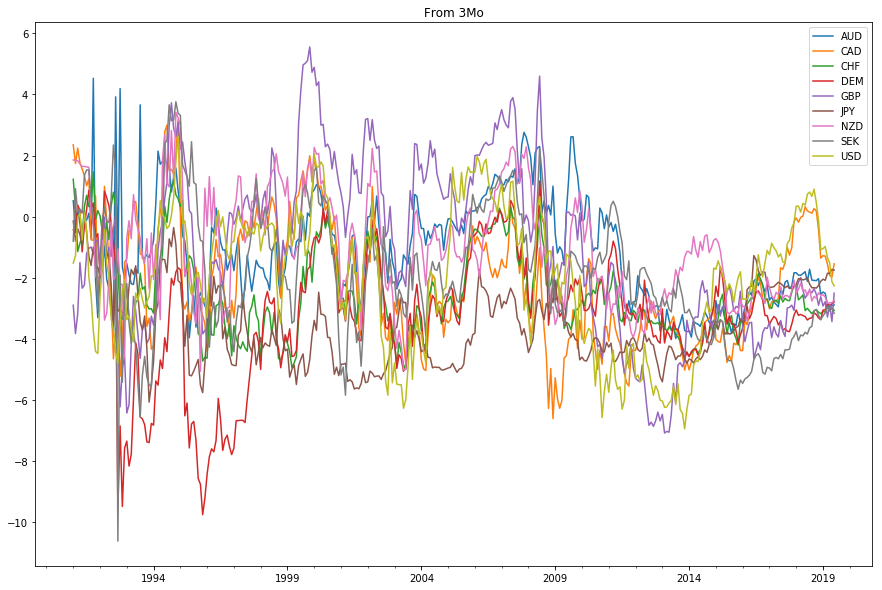

In [57]:
df_curvature_all_tenors1.loc[:,cond].plot(figsize=(15,10), title='From 3Mo')

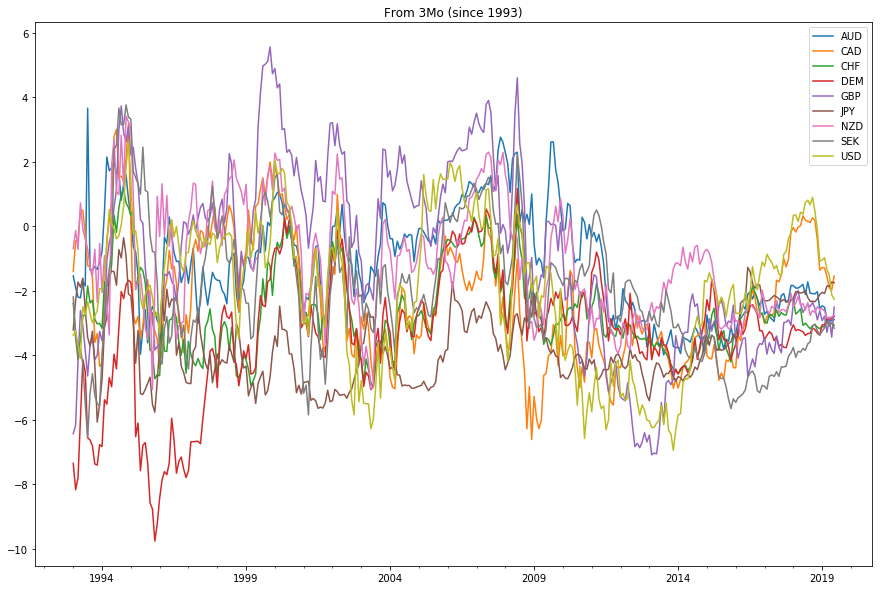

In [58]:
df_curvature_all_tenors1.loc['1993':,cond].plot(figsize=(15,10), title='From 3Mo (since 1993)')

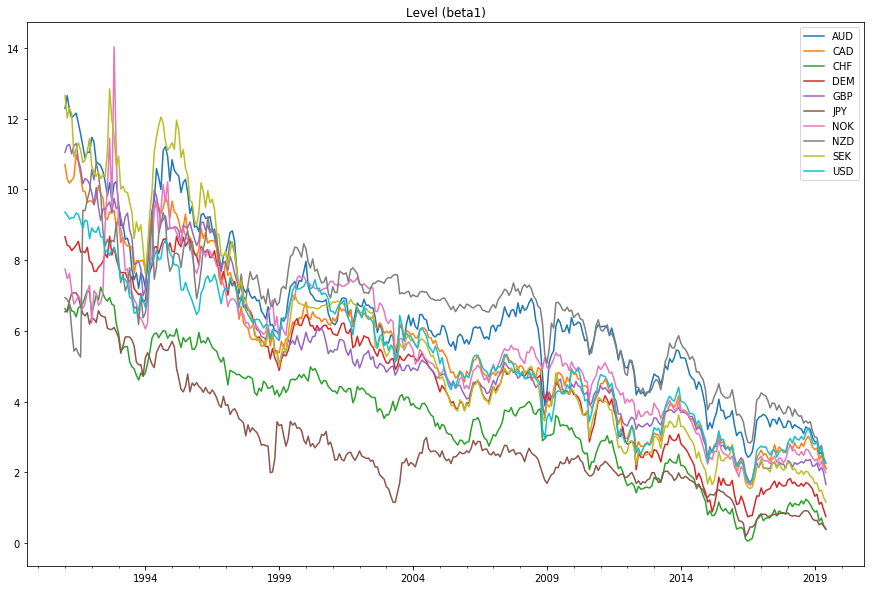

In [59]:
df_level_all_tenors1 = pd.DataFrame(index=calendar_curves, columns=lista_moedas_aux)
for moeda in lista_moedas_aux:
    df_level_all_tenors1[moeda] = df_betas1.loc[(moeda),'b1']
df_level_all_tenors1.plot(figsize=(15,10), title="Level (beta1)")

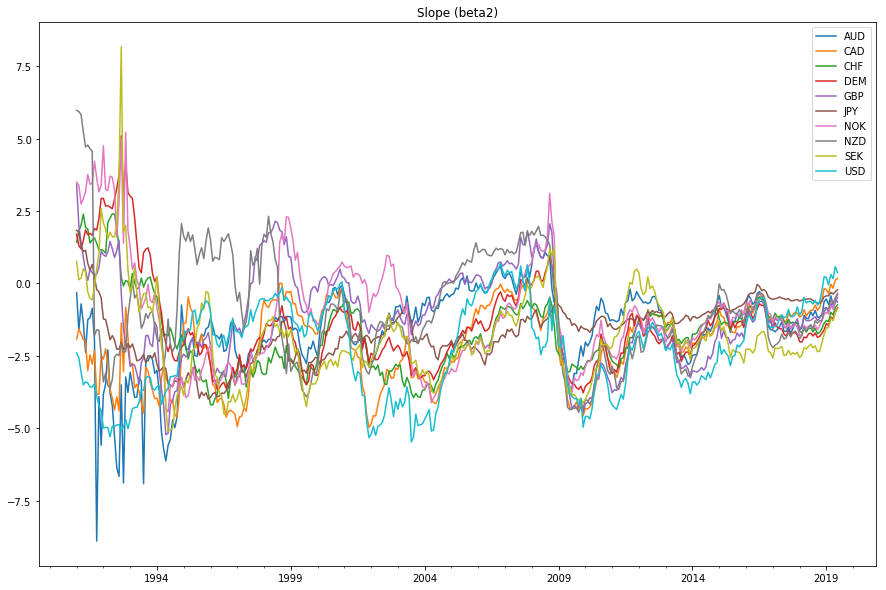

In [60]:
df_slope_all_tenors1 = pd.DataFrame(index=calendar_curves, columns=lista_moedas_aux)
for moeda in lista_moedas_aux:
    df_slope_all_tenors1[moeda] = df_betas1.loc[(moeda),'b2']
df_slope_all_tenors1.plot(figsize=(15,10), title="Slope (beta2)")

### Starting from 3 months looks better

In [61]:
Stdev_b3 = pd.DataFrame(df_curvature_all_tenors.std(), columns=['All tenors'])
Stdev_b3['From 3Mo on'] = df_curvature_all_tenors1.std()
Stdev_b3['Dif'] = Stdev_b3['From 3Mo on'] - Stdev_b3['All tenors']
Stdev_b3

,All tenors,From 3Mo on,Dif
AUD,1.736414,1.689582,-0.046833
CAD,2.076183,1.947457,-0.128725
CHF,1.417224,1.424937,0.007713
DEM,2.125362,2.125362,0.000000
GBP,2.496234,2.787497,0.291263
JPY,1.093741,1.269911,0.176170
NOK,14.028472,2.331709,-11.696763
NZD,1.750163,1.741709,-0.008454
SEK,3.560391,2.124262,-1.436128
USD,2.074342,2.170299,0.095957


### Signals from Curvature

In [62]:
#Inicializando DataFrame
# Parametros
# calendar_curves
lst_currencies = list(df_tickers.index)
relative_curvature = pd.DataFrame(index=calendar_curves, columns=lst_currencies)
ranks_curvature = pd.DataFrame(index=calendar_curves, columns=lst_currencies)

#### Relative Curvature:
Curvature loading from a country - US curvature (beta3)

In [63]:
relative_curvature = df_curvature_all_tenors1[lst_currencies]
for moeda in lst_currencies:
    relative_curvature.loc[:,moeda] = relative_curvature.loc[:,moeda] - df_curvature_all_tenors1.loc[:,'USD']

C:\ProgramData\Anaconda3\lib\site-packages\pandas\core\indexing.py:630: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self.obj[item_labels[indexer[info_axis]]] = value


In [64]:
for d in calendar_curves:
    available_FX = list(relative_curvature.loc[d].dropna(how='any').index)
    ranks_curvature.loc[d,available_FX] = relative_curvature.loc[d, available_FX].rank(ascending=True)

In [65]:
ranks_curvature.tail()

,AUD,CAD,CHF,DEM,GBP,JPY,NOK,NZD,SEK
2019-02-28,6,8,2,3,4,7,9,5,1
2019-03-29,4,8,3,5,1,7,9,6,2
2019-04-30,3,7,2,4,5,8,9,6,1
2019-05-31,4,7,2,5,1,8,9,6,3
2019-06-28,3,8,2,4,6,7,9,5,1


### P&L of curvature strategy

In [66]:
[TR_index1_c, holdings1_c, weights1_c, signals1_c] = pnl_fwd_dsc(fwd_last_USDXXX, spot_last_USDXXX, ranks_curvature, k=1)
[TR_index2_c, holdings2_c, weights2_c, signals2_c] = pnl_fwd_dsc(fwd_last_USDXXX, spot_last_USDXXX, ranks_curvature, k=2)
[TR_index3_c, holdings3_c, weights3_c, signals3_c] = pnl_fwd_dsc(fwd_last_USDXXX, spot_last_USDXXX, ranks_curvature, k=3)
[TR_index4_c, holdings4_c, weights4_c, signals4_c] = pnl_fwd_dsc(fwd_last_USDXXX, spot_last_USDXXX, ranks_curvature, k=4)

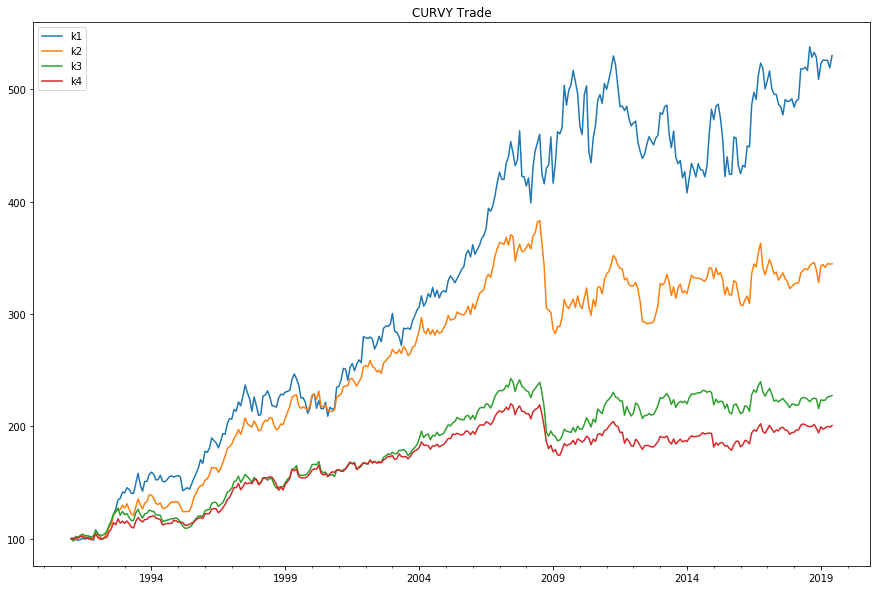

In [67]:
TR_curvy = pd.DataFrame(index=TR_index1_c.index, columns=['k1','k2','k3','k4'])
TR_curvy['k1'] = TR_index1_c
TR_curvy['k2'] = TR_index2_c
TR_curvy['k3'] = TR_index3_c
TR_curvy['k4'] = TR_index4_c
TR_curvy.plot(figsize=(15,10), title='CURVY Trade')

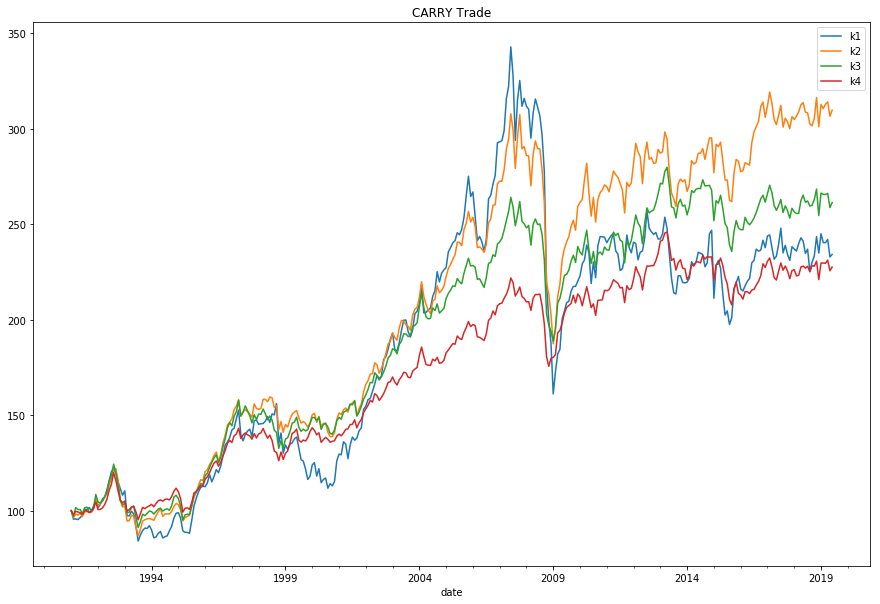

In [68]:
TR_dsc.plot(figsize=(15,10), title='CARRY Trade')

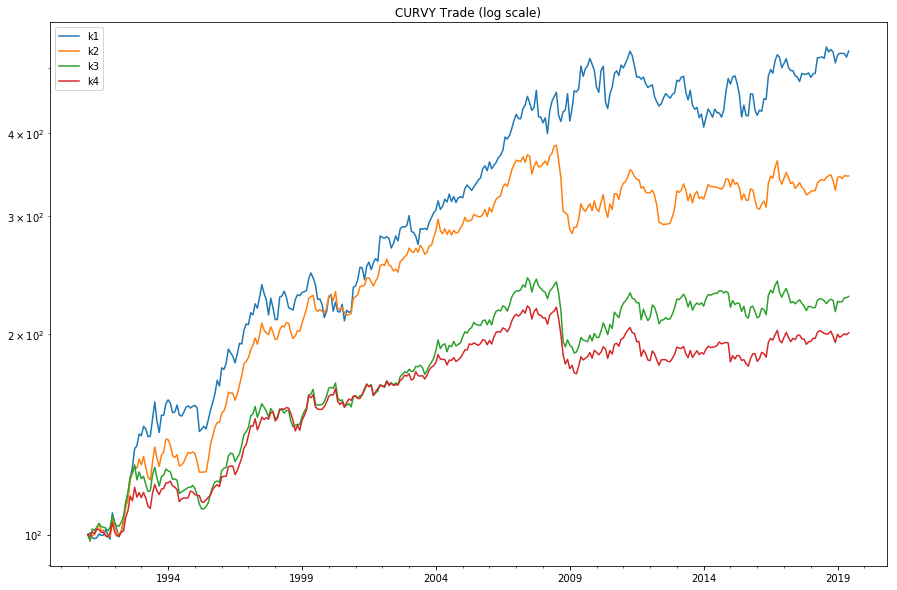

In [69]:
TR_curvy.plot(figsize=(15,10), title='CURVY Trade (log scale)', logy=True)

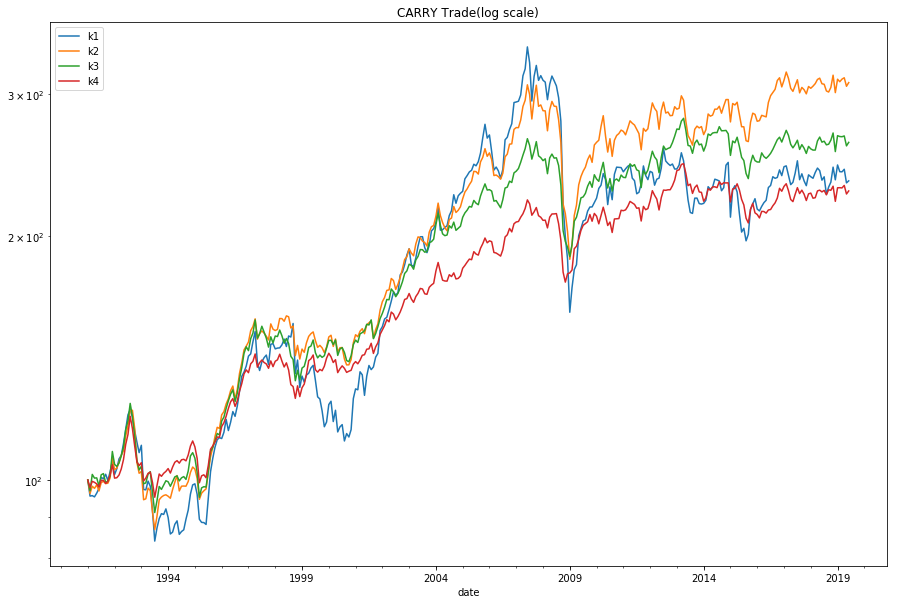

In [70]:
TR_dsc.plot(figsize=(15,10), title='CARRY Trade(log scale)', logy=True)

# P&L of equal vol curvy trade

In [71]:
#using pnl_equal_vol() function
tgt_vol_curvy = 0.09
[TR_crv_ev1, holdings_crv_ev1, weights_crv_ev1, signals_crv_ev1] = pnl_equal_vol(fwd_last_USDXXX, spot_last_USDXXX, ranks_curvature, df_vols_monthly, tgt_vol_curvy, k=1)
[TR_crv_ev2, holdings_crv_ev2, weights_crv_ev2, signals_crv_ev2] = pnl_equal_vol(fwd_last_USDXXX, spot_last_USDXXX, ranks_curvature, df_vols_monthly, tgt_vol_curvy, k=2)
[TR_crv_ev3, holdings_crv_ev3, weights_crv_ev3, signals_crv_ev3] = pnl_equal_vol(fwd_last_USDXXX, spot_last_USDXXX, ranks_curvature, df_vols_monthly, tgt_vol_curvy, k=3)
[TR_crv_ev4, holdings_crv_ev4, weights_crv_ev4, signals_crv_ev4] = pnl_equal_vol(fwd_last_USDXXX, spot_last_USDXXX, ranks_curvature, df_vols_monthly, tgt_vol_curvy, k=4)

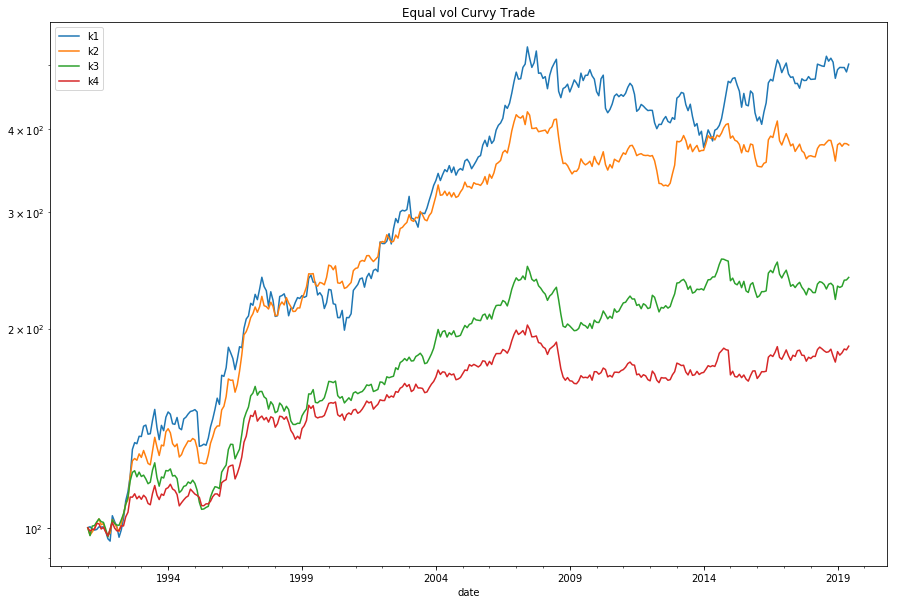

In [72]:
TR_crv_ev = pd.DataFrame(index=TR_dsc_ev1.index, columns=['k1','k2','k3','k4'])
TR_crv_ev['k1'] = TR_crv_ev1
TR_crv_ev['k2'] = TR_crv_ev2
TR_crv_ev['k3'] = TR_crv_ev3
TR_crv_ev['k4'] = TR_crv_ev4
TR_crv_ev.plot(figsize=(15,10), title='Equal vol Curvy Trade', logy=True)

### Signals and P&L for Level

In [73]:
#Inicializando DataFrame
# Parametros
# calendar_curves
lst_currencies = list(df_tickers.index)
relative_level = pd.DataFrame(index=calendar_curves, columns=lst_currencies)
ranks_level = pd.DataFrame(index=calendar_curves, columns=lst_currencies)
relative_level = df_level_all_tenors1[lst_currencies]
for moeda in lst_currencies:
    relative_level.loc[:,moeda] = relative_level.loc[:,moeda] - df_level_all_tenors1.loc[:,'USD']
for d in calendar_curves:
    available_FX = list(relative_level.loc[d].dropna(how='any').index)
    ranks_level.loc[d,available_FX] = relative_level.loc[d, available_FX].rank(ascending=True)

In [74]:
[TR_index1_l, holdings1_l, weights1_l, signals1_l] = pnl_fwd_dsc(fwd_last_USDXXX, spot_last_USDXXX, ranks_level, k=1)
[TR_index2_l, holdings2_l, weights2_l, signals2_l] = pnl_fwd_dsc(fwd_last_USDXXX, spot_last_USDXXX, ranks_level, k=2)
[TR_index3_l, holdings3_l, weights3_l, signals3_l] = pnl_fwd_dsc(fwd_last_USDXXX, spot_last_USDXXX, ranks_level, k=3)
[TR_index4_l, holdings4_l, weights4_l, signals4_l] = pnl_fwd_dsc(fwd_last_USDXXX, spot_last_USDXXX, ranks_level, k=4)

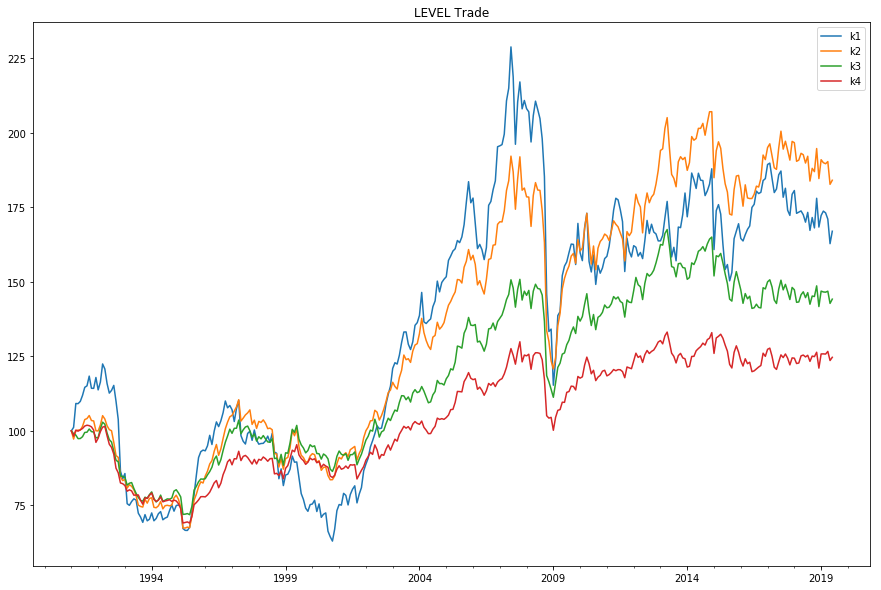

In [75]:
TR_level = pd.DataFrame(index=TR_index1_c.index, columns=['k1','k2','k3','k4'])
TR_level['k1'] = TR_index1_l
TR_level['k2'] = TR_index2_l
TR_level['k3'] = TR_index3_l
TR_level['k4'] = TR_index4_l
TR_level.plot(figsize=(15,10), title='LEVEL Trade')

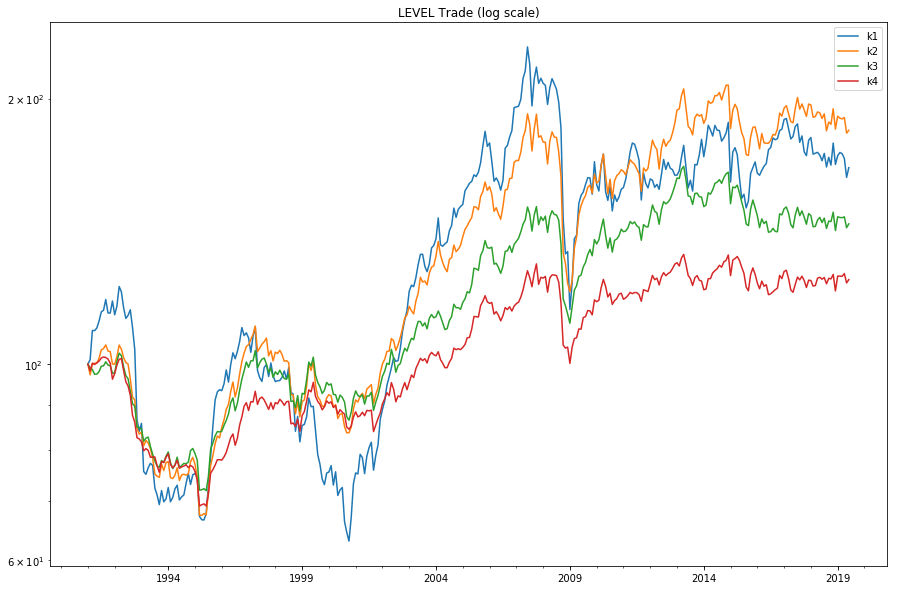

In [76]:
TR_level.plot(figsize=(15,10), title='LEVEL Trade (log scale)', logy=True)

### Signals and P&L for Slope

In [77]:
#Inicializando DataFrame
# Parametros
# calendar_curves
lst_currencies = list(df_tickers.index)
relative_slope = pd.DataFrame(index=calendar_curves, columns=lst_currencies)
ranks_slope = pd.DataFrame(index=calendar_curves, columns=lst_currencies)
relative_slope = df_slope_all_tenors1[lst_currencies]
for moeda in lst_currencies:
    relative_slope.loc[:,moeda] = relative_slope.loc[:,moeda] - df_slope_all_tenors1.loc[:,'USD']
for d in calendar_curves:
    available_FX = list(relative_slope.loc[d].dropna(how='any').index)
    ranks_slope.loc[d,available_FX] = relative_slope.loc[d, available_FX].rank(ascending=True)

In [78]:
[TR_index1_s, holdings1_s, weights1_s, signals1_s] = pnl_fwd_dsc(fwd_last_USDXXX, spot_last_USDXXX, ranks_slope, k=1)
[TR_index2_s, holdings2_s, weights2_s, signals2_s] = pnl_fwd_dsc(fwd_last_USDXXX, spot_last_USDXXX, ranks_slope, k=2)
[TR_index3_s, holdings3_s, weights3_s, signals3_s] = pnl_fwd_dsc(fwd_last_USDXXX, spot_last_USDXXX, ranks_slope, k=3)
[TR_index4_s, holdings4_s, weights4_s, signals4_s] = pnl_fwd_dsc(fwd_last_USDXXX, spot_last_USDXXX, ranks_slope, k=4)

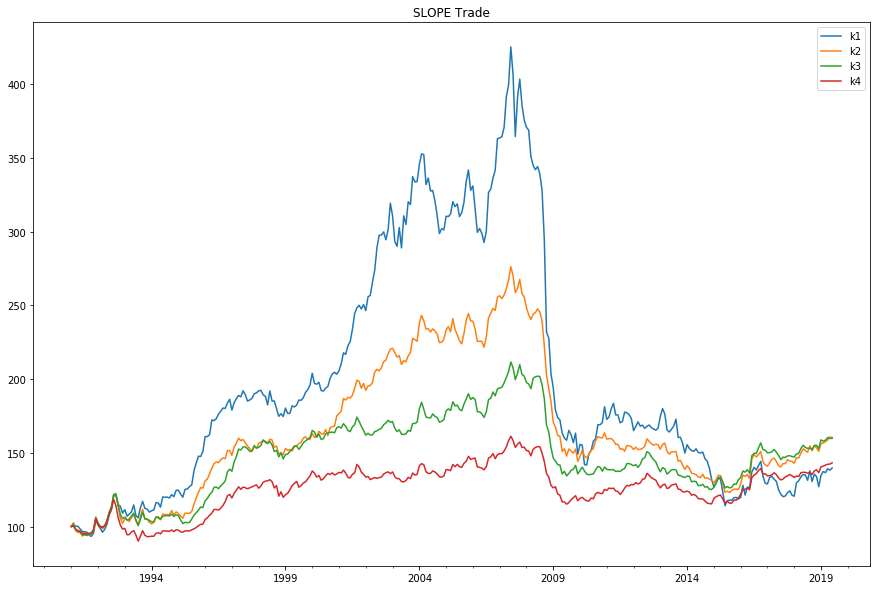

In [79]:
TR_slope = pd.DataFrame(index=TR_index1_c.index, columns=['k1','k2','k3','k4'])
TR_slope['k1'] = TR_index1_s
TR_slope['k2'] = TR_index2_s
TR_slope['k3'] = TR_index3_s
TR_slope['k4'] = TR_index4_s
TR_slope.plot(figsize=(15,10), title='SLOPE Trade')

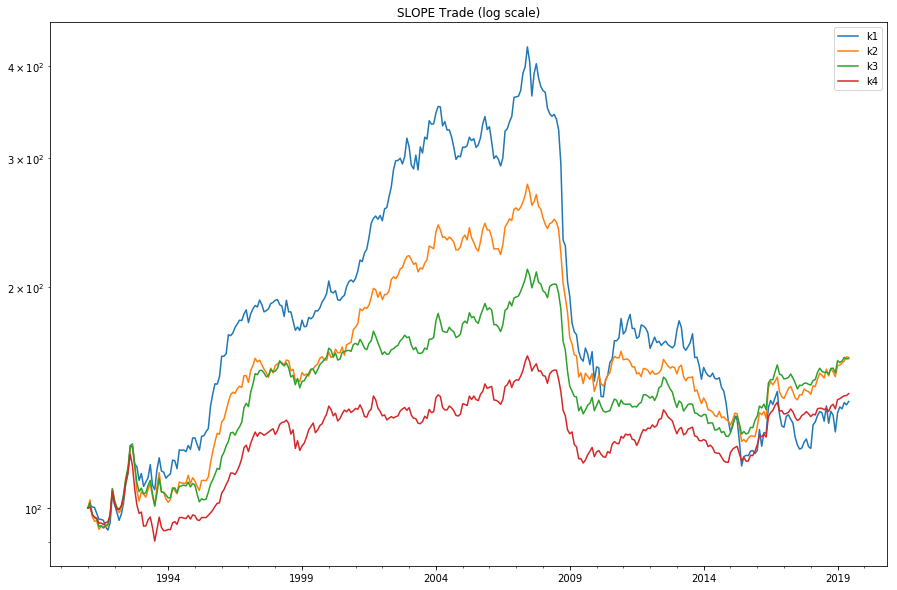

In [80]:
TR_slope.plot(figsize=(15,10), title='SLOPE Trade (log scale)', logy=True)

### Tables 04 and 05

In [81]:
#table04 Funding Currencies
table04_Funding.loc[('Curvature', 1)] = (signals1_c<-0.01).sum()
table04_Funding.loc[('Curvature', 2)] = (signals2_c<-0.01).sum()
table04_Funding.loc[('Curvature', 3)] = (signals3_c<-0.01).sum()
table04_Funding.loc[('Curvature', 4)] = (signals4_c<-0.01).sum()
#table05 Investing Currencies
table05_Investing.loc[('Curvature', 1)] = (signals1_c>0.01).sum()
table05_Investing.loc[('Curvature', 2)] = (signals2_c>0.01).sum()
table05_Investing.loc[('Curvature', 3)] = (signals3_c>0.01).sum()
table05_Investing.loc[('Curvature', 4)] = (signals4_c>0.01).sum()

In [82]:
table04_Funding

AUD  CAD  CHF  DEM  GBP  JPY  NOK  NZD  SEK
Strategy         k                                             
Forward discount 1    1    0  120    1    0  217    2    0    1
                 2    9   16  310   19    0  278    4    1   47
                 3   23   63  318  151   11  308   30   11  111
                 4   27  120  329  234   56  342   74   21  165
Curvature        1    7   34    6   64   34  140    4    4   49
                 2   10  105   54  120   66  207   32   12   78
                 3   25  135  154  199   83  250   45   35  100
                 4   58  170  240  267  107  271   62   64  129

In [83]:
table05_Investing

AUD  CAD  CHF  DEM  GBP  JPY  NOK  NZD  SEK
Strategy         k                                             
Forward discount 1   58    0    0    9   10    0   55  177   33
                 2  195    6    0   23   51    0   75  284   50
                 3  278   42    2   47  108    0  190  292   67
                 4  305  109    4   84  197    0  236  304  129
Curvature        1   50   28    0    0  125    6   41   62   30
                 2  123   58    6    7  158   17  106  139   70
                 3  183   92   31   14  189   33  177  197  110
                 4  249  129   62   40  215   54  236  234  149

### Table 03

In [84]:
from scipy.stats import skew
from scipy.stats import kurtosis

In [85]:
def GetPerformanceTable(IndexSeries, freq='Daily'):
    adju_factor = 252.0
    if freq == 'Monthly':
        adju_factor = 12.0
    elif freq == 'Weekly':
        adju_factor = 52.0

    Table = pd.Series(index=['Excess Return','Volatility','Sharpe','Sortino','Max Drawdown',
                             'Max Drawdown in Vol Terms','5th percentile in Vol Terms','10th percentile in Vol Terms'])

    CleanIndexSeries = IndexSeries.dropna().sort_index()

    ER_index = pd.Series(index=CleanIndexSeries.index)
    ER_index[CleanIndexSeries.index[0]] = 100.0
    for d,d_minus_1 in zip(ER_index.index[1:],ER_index.index[:-1]):
        ER = CleanIndexSeries[d]/CleanIndexSeries[d_minus_1]-1.0
        ER_index[d] = ER_index[d_minus_1]*(1+ER)

    Retornos = CleanIndexSeries.pct_change(1)
    Retorno_medio = CleanIndexSeries.pct_change(1).mean()
    Table['Excess Return'] = (CleanIndexSeries[-1]/CleanIndexSeries[0])**(adju_factor/(len(CleanIndexSeries)-1.0))-1
    Table['Volatility'] = (np.log(ER_index).diff(1).dropna()).std()*np.sqrt(adju_factor)
    Table['Sharpe'] = Table['Excess Return']/Table['Volatility']
    Table['Sortino'] = Table['Excess Return']/(np.sqrt(adju_factor)*(np.log(ER_index).diff(1).dropna()[np.log(ER_index).diff(1).dropna()<0.0]).std())
    Table['Skewness'] = skew(Retornos.dropna())
    Table['Kurtosis'] = kurtosis(Retornos.dropna())
    Table['Max Drawdown'] = max_dd(ER_index)
    Table['Max Drawdown in Vol Terms'] = max_dd(ER_index)/Table['Volatility']
    Table['5th percentile in Vol Terms'] = (ER_index.pct_change(1).dropna()).quantile(q=0.05)/Table['Volatility']
    Table['10th percentile in Vol Terms'] = (ER_index.pct_change(1).dropna()).quantile(q=0.1)/Table['Volatility']
    return Table

def max_dd(ser):
    max2here = ser.expanding(min_periods=1).max()
    dd2here = ser/max2here - 1.0
    return dd2here.min()

In [86]:
idx5 = pd.MultiIndex.from_product(iterables=[['Forward discount', 'Equal vol carry', 'Level', 'Slope', 'Curvature', 'Equal vol curvy'], range(1,5)], names=['Sorting', 'k'])
colunas = ['Mean annual', 'Stdev annual', 'Skewness monthly', 'Kurtosis monthly', 'Sharpe ratio']
table03 = pd.DataFrame(index=idx5, columns=colunas)

In [87]:
table03

Mean annual Stdev annual Skewness monthly Kurtosis monthly  \
Sorting          k                                                              
Forward discount 1         NaN          NaN              NaN              NaN   
                 2         NaN          NaN              NaN              NaN   
                 3         NaN          NaN              NaN              NaN   
                 4         NaN          NaN              NaN              NaN   
Equal vol carry  1         NaN          NaN              NaN              NaN   
                 2         NaN          NaN              NaN              NaN   
                 3         NaN          NaN              NaN              NaN   
                 4         NaN          NaN              NaN              NaN   
Level            1         NaN          NaN              NaN              NaN   
                 2         NaN          NaN              NaN              NaN   
                 3         NaN          NaN              NaN              NaN   
                 4         NaN          NaN              NaN              NaN   
Slope            1         NaN          NaN              NaN              NaN   
                 2         NaN          NaN              NaN              NaN   
                 3         NaN          NaN              NaN              NaN   
                 4         NaN          NaN              NaN              NaN   
Curvature        1         NaN          NaN              NaN              NaN   
                 2         NaN          NaN              NaN              NaN   
                 3         NaN          NaN              NaN              NaN   
                 4         NaN          NaN              NaN              NaN   
Equal vol curvy  1         NaN          NaN              NaN              NaN   
                 2         NaN          NaN              NaN              NaN   
                 3         NaN          NaN              NaN              NaN   
                 4         NaN          NaN              NaN              NaN   

                   Sharpe ratio  
Sorting          k               
Forward discount 1          NaN  
                 2          NaN  
                 3          NaN  
                 4          NaN  
Equal vol carry  1          NaN  
                 2          NaN  
                 3          NaN  
                 4          NaN  
Level            1          NaN  
                 2          NaN  
                 3          NaN  
                 4          NaN  
Slope            1          NaN  
                 2          NaN  
                 3          NaN  
                 4          NaN  
Curvature        1          NaN  
                 2          NaN  
                 3          NaN  
                 4          NaN  
Equal vol curvy  1          NaN  
                 2          NaN  
                 3          NaN  
                 4          NaN

In [88]:
mean_annual_curvy = lambda k: GetPerformanceTable(TR_curvy["k" + str(k)], freq='Monthly')['Excess Return'] * 100
mean_annual_crv_ev = lambda k: GetPerformanceTable(TR_crv_ev["k" + str(k)], freq='Monthly')['Excess Return'] * 100
mean_annual_dsc = lambda k: GetPerformanceTable(TR_dsc["k" + str(k)], freq='Monthly')['Excess Return'] * 100
mean_annual_dsc_ev = lambda k: GetPerformanceTable(TR_dsc_ev["k" + str(k)], freq='Monthly')['Excess Return'] * 100
mean_annual_level = lambda k: GetPerformanceTable(TR_level["k" + str(k)], freq='Monthly')['Excess Return'] * 100
mean_annual_slope = lambda k: GetPerformanceTable(TR_slope["k" + str(k)], freq='Monthly')['Excess Return'] * 100

In [89]:
vol_annual_curvy = lambda k: GetPerformanceTable(TR_curvy["k" + str(k)], freq='Monthly')['Volatility'] * 100
vol_annual_crv_ev = lambda k: GetPerformanceTable(TR_crv_ev["k" + str(k)], freq='Monthly')['Volatility'] * 100
vol_annual_dsc = lambda k: GetPerformanceTable(TR_dsc["k" + str(k)], freq='Monthly')['Volatility'] * 100
vol_annual_dsc_ev = lambda k: GetPerformanceTable(TR_dsc_ev["k" + str(k)], freq='Monthly')['Volatility'] * 100
vol_annual_level = lambda k: GetPerformanceTable(TR_level["k" + str(k)], freq='Monthly')['Volatility'] * 100
vol_annual_slope = lambda k: GetPerformanceTable(TR_slope["k" + str(k)], freq='Monthly')['Volatility'] * 100

In [90]:
sharpe_annual_curvy = lambda k: GetPerformanceTable(TR_curvy["k" + str(k)], freq='Monthly')['Sharpe'] 
sharpe_annual_crv_ev = lambda k: GetPerformanceTable(TR_crv_ev["k" + str(k)], freq='Monthly')['Sharpe'] 
sharpe_annual_dsc = lambda k: GetPerformanceTable(TR_dsc["k" + str(k)], freq='Monthly')['Sharpe'] 
sharpe_annual_dsc_ev = lambda k: GetPerformanceTable(TR_dsc_ev["k" + str(k)], freq='Monthly')['Sharpe'] 
sharpe_annual_level = lambda k: GetPerformanceTable(TR_level["k" + str(k)], freq='Monthly')['Sharpe']
sharpe_annual_slope = lambda k: GetPerformanceTable(TR_slope["k" + str(k)], freq='Monthly')['Sharpe']

In [91]:
skew_annual_curvy = lambda k: GetPerformanceTable(TR_curvy["k" + str(k)], freq='Monthly')['Skewness'] 
skew_annual_crv_ev = lambda k: GetPerformanceTable(TR_crv_ev["k" + str(k)], freq='Monthly')['Skewness'] 
skew_annual_dsc = lambda k: GetPerformanceTable(TR_dsc["k" + str(k)], freq='Monthly')['Skewness'] 
skew_annual_dsc_ev = lambda k: GetPerformanceTable(TR_dsc_ev["k" + str(k)], freq='Monthly')['Skewness'] 
skew_annual_level = lambda k: GetPerformanceTable(TR_level["k" + str(k)], freq='Monthly')['Skewness']
skew_annual_slope = lambda k: GetPerformanceTable(TR_slope["k" + str(k)], freq='Monthly')['Skewness']

In [92]:
kurt_annual_curvy = lambda k: GetPerformanceTable(TR_curvy["k" + str(k)], freq='Monthly')['Kurtosis'] 
kurt_annual_crv_ev = lambda k: GetPerformanceTable(TR_crv_ev["k" + str(k)], freq='Monthly')['Kurtosis'] 
kurt_annual_dsc = lambda k: GetPerformanceTable(TR_dsc["k" + str(k)], freq='Monthly')['Kurtosis'] 
kurt_annual_dsc_ev = lambda k: GetPerformanceTable(TR_dsc_ev["k" + str(k)], freq='Monthly')['Kurtosis'] 
kurt_annual_level = lambda k: GetPerformanceTable(TR_level["k" + str(k)], freq='Monthly')['Kurtosis']
kurt_annual_slope = lambda k: GetPerformanceTable(TR_slope["k" + str(k)], freq='Monthly')['Kurtosis']

In [93]:
table03.loc[('Curvature', ), 'Mean annual'] = [mean_annual_curvy(k) for k in range(1,5)]
table03.loc[('Equal vol curvy', ), 'Mean annual'] = [mean_annual_crv_ev(k) for k in range(1,5)]
table03.loc[('Forward discount', ), 'Mean annual'] = [mean_annual_dsc(k) for k in range(1,5)]
table03.loc[('Equal vol carry', ), 'Mean annual'] = [mean_annual_dsc_ev(k) for k in range(1,5)]
table03.loc[('Level', ), 'Mean annual'] = [mean_annual_level(k) for k in range(1,5)]
table03.loc[('Slope', ), 'Mean annual'] = [mean_annual_slope(k) for k in range(1,5)]
table03

C:\ProgramData\Anaconda3\lib\site-packages\IPython\core\async_helpers.py:67: PerformanceWarning: indexing past lexsort depth may impact performance.
  coro.send(None)


Mean annual Stdev annual Skewness monthly Kurtosis monthly  \
Sorting          k                                                              
Forward discount 1     3.04098          NaN              NaN              NaN   
                 2     4.05981          NaN              NaN              NaN   
                 3     3.43894          NaN              NaN              NaN   
                 4     2.93687          NaN              NaN              NaN   
Equal vol carry  1     2.62988          NaN              NaN              NaN   
                 2     4.27331          NaN              NaN              NaN   
                 3       4.331          NaN              NaN              NaN   
                 4     3.27369          NaN              NaN              NaN   
Level            1     1.82078          NaN              NaN              NaN   
                 2      2.1709          NaN              NaN              NaN   
                 3     1.29655          NaN              NaN              NaN   
                 4    0.779375          NaN              NaN              NaN   
Slope            1     1.18298          NaN              NaN              NaN   
                 2     1.67849          NaN              NaN              NaN   
                 3      1.6642          NaN              NaN              NaN   
                 4     1.27143          NaN              NaN              NaN   
Curvature        1     6.04448          NaN              NaN              NaN   
                 2        4.45          NaN              NaN              NaN   
                 3     2.93285          NaN              NaN              NaN   
                 4     2.48078          NaN              NaN              NaN   
Equal vol curvy  1     5.84132          NaN              NaN              NaN   
                 2     4.79781          NaN              NaN              NaN   
                 3     3.11319          NaN              NaN              NaN   
                 4     2.24834          NaN              NaN              NaN   

                   Sharpe ratio  
Sorting          k               
Forward discount 1          NaN  
                 2          NaN  
                 3          NaN  
                 4          NaN  
Equal vol carry  1          NaN  
                 2          NaN  
                 3          NaN  
                 4          NaN  
Level            1          NaN  
                 2          NaN  
                 3          NaN  
                 4          NaN  
Slope            1          NaN  
                 2          NaN  
                 3          NaN  
                 4          NaN  
Curvature        1          NaN  
                 2          NaN  
                 3          NaN  
                 4          NaN  
Equal vol curvy  1          NaN  
                 2          NaN  
                 3          NaN  
                 4          NaN

In [94]:
table03.loc[('Curvature', ), 'Stdev annual'] = [vol_annual_curvy(k) for k in range(1,5)]
table03.loc[('Equal vol curvy', ), 'Stdev annual'] = [vol_annual_crv_ev(k) for k in range(1,5)]
table03.loc[('Forward discount', ), 'Stdev annual'] = [vol_annual_dsc(k) for k in range(1,5)]
table03.loc[('Equal vol carry', ), 'Stdev annual'] = [vol_annual_dsc_ev(k) for k in range(1,5)]
table03.loc[('Level', ), 'Stdev annual'] = [vol_annual_level(k) for k in range(1,5)]
table03.loc[('Slope', ), 'Stdev annual'] = [vol_annual_slope(k) for k in range(1,5)]

In [95]:
table03.loc[('Curvature', ), 'Sharpe ratio'] = [sharpe_annual_curvy(k) for k in range(1,5)]
table03.loc[('Equal vol curvy', ), 'Sharpe ratio'] = [sharpe_annual_crv_ev(k) for k in range(1,5)]
table03.loc[('Forward discount', ), 'Sharpe ratio'] = [sharpe_annual_dsc(k) for k in range(1,5)]
table03.loc[('Equal vol carry', ), 'Sharpe ratio'] = [sharpe_annual_dsc_ev(k) for k in range(1,5)]
table03.loc[('Level', ), 'Sharpe ratio'] = [sharpe_annual_level(k) for k in range(1,5)]
table03.loc[('Slope', ), 'Sharpe ratio'] = [sharpe_annual_slope(k) for k in range(1,5)]

In [96]:
table03.loc[('Curvature', ), 'Skewness monthly'] = [skew_annual_curvy(k) for k in range(1,5)]
table03.loc[('Equal vol curvy', ), 'Skewness monthly'] = [skew_annual_crv_ev(k) for k in range(1,5)]
table03.loc[('Forward discount', ), 'Skewness monthly'] = [skew_annual_dsc(k) for k in range(1,5)]
table03.loc[('Equal vol carry', ), 'Skewness monthly'] = [skew_annual_dsc_ev(k) for k in range(1,5)]
table03.loc[('Level', ), 'Skewness monthly'] = [skew_annual_level(k) for k in range(1,5)]
table03.loc[('Slope', ), 'Skewness monthly'] = [skew_annual_slope(k) for k in range(1,5)]

In [97]:
table03.loc[('Curvature', ), 'Kurtosis monthly'] = [kurt_annual_curvy(k) for k in range(1,5)]
table03.loc[('Equal vol curvy', ), 'Kurtosis monthly'] = [kurt_annual_crv_ev(k) for k in range(1,5)]
table03.loc[('Forward discount', ), 'Kurtosis monthly'] = [kurt_annual_dsc(k) for k in range(1,5)]
table03.loc[('Equal vol carry', ), 'Kurtosis monthly'] = [kurt_annual_dsc_ev(k) for k in range(1,5)]
table03.loc[('Level', ), 'Kurtosis monthly'] = [kurt_annual_level(k) for k in range(1,5)]
table03.loc[('Slope', ), 'Kurtosis monthly'] = [kurt_annual_slope(k) for k in range(1,5)]

In [98]:
table03

Mean annual Stdev annual Skewness monthly Kurtosis monthly  \
Sorting          k                                                              
Forward discount 1     3.04098      13.2889         -1.22552           4.3534   
                 2     4.05981      10.2253        -0.940694          2.94386   
                 3     3.43894      8.65828        -0.684788          1.69247   
                 4     2.93687       7.0364        -0.613295          1.17837   
Equal vol carry  1     2.62988      11.2238        -0.654232          1.91486   
                 2     4.27331      8.72274        -0.391348         0.266586   
                 3       4.331      7.83373        -0.206496         0.690047   
                 4     3.27369      6.68043         -0.41154         0.998349   
Level            1     1.82078       14.672        -0.987223          3.18526   
                 2      2.1709      10.5946         -0.99965          3.97693   
                 3     1.29655      8.30629        -0.804623          2.94098   
                 4    0.779375      6.91324        -0.792671          2.42329   
Slope            1     1.18298        12.37        -0.757742          4.01383   
                 2     1.67849      8.48617       -0.0752347          1.82966   
                 3      1.6642      7.32643      -0.00656913          2.68596   
                 4     1.27143      6.37847        -0.140817          1.91647   
Curvature        1     6.04448      10.9715       -0.0870751          0.83123   
                 2        4.45      8.44907         -0.24062          1.35905   
                 3     2.93285      7.32681        -0.409667          1.75456   
                 4     2.48078       6.3869        -0.340831          1.01965   
Equal vol curvy  1     5.84132      11.0619        -0.129796          1.29715   
                 2     4.79781      8.12853         0.232515          1.00146   
                 3     3.11319      6.98347       -0.0880263         0.727176   
                 4     2.24834      6.01917        -0.255375          1.95881   

                   Sharpe ratio  
Sorting          k               
Forward discount 1     0.228836  
                 2     0.397037  
                 3     0.397185  
                 4     0.417383  
Equal vol carry  1     0.234313  
                 2     0.489905  
                 3     0.552865  
                 4     0.490042  
Level            1     0.124099  
                 2     0.204907  
                 3     0.156093  
                 4     0.112737  
Slope            1    0.0956325  
                 2     0.197791  
                 3      0.22715  
                 4     0.199331  
Curvature        1     0.550926  
                 2     0.526685  
                 3      0.40029  
                 4     0.388417  
Equal vol curvy  1     0.528055  
                 2     0.590244  
                 3     0.445793  
                 4      0.37353

# TO DOs
- Utilização de pesos alternativos na construção dos portfolios.
    - Ponderação por spread ou risco (tanto para carry trade como curvy trade). Paper usa pesos iguais.
        - pensar em um codigo que faça isso e ver eventuais restrições (limite de concentracao, alavancagem, etc)
- Backtesting de dados diários (paper é mensal).
    - gardar matriz de posições para marcar o MtM
- Plotting dos betas Vs USD ao longo do tempo.
    - montar um indice de USD para calcular o beta
- Regressões para testar fatores explicativos dos retornos do portfolio (ex: CRB, vol implícita, liquidez)
    - buscar series na bbg
